# Prediction of EV Charging station installed in ABQ, NM

## Project Problems




Q1) How will the trend of EV cars look like in the next 12 month?
- How many EV cars are per zip code?

Q2) What is the trend of number of EV charging stations in the next months?
Q3) Does the growth of the surronding area of EV charging station help to drive the growth of EV charging business?

Note:
We can add more questions based on the data we can find.

## Direction for data processing

To find the profitable locations and business factors that drive the growth of an EV charging station business, here can be the project focuses (based on the data we have):

1. Group by 'ZIP Code', Plot the number of EV counts per year to see the trend changing from the the past to the present. From this dataset, the data has been collected from Jan 2010 to Jul 2025 in each zip code.

  1.1 Filter only the zip codes located in ABQ

2. Create a time series model to predict the growth of three components in  ABQ;

  2.1 No. of EV users registration

  2.2 No. of EV charging stations
  
  2.3 No. and types of business



## Expected Outcomes

- We can use the data outcomes from this data processing to taking into consideration the marker growth-driving factors:
  - To answer where we can estimate/ predict new locations for new EV charging stations with the fastest charging speed (DC) in ABQ.

In order to answer this question,
  (1) From the EV charging station dataset, where are the most located EV charging stations -> the fastest chargers should be installed more in the new charging stations for customers' convenience.

  (2) For customers' convenience, how many businesses are located in each zip code -> where can these businesses support the growth of new EV charing stations in new locations? To be convenient spots for EV drivers.
  
  (3) Within the area codes of EV user registration, how far of the targeted location from where EV users reside? -> Where/What can these EV users go or do errands while charging their cars

## Setup

In [1]:
%%capture
%%bash
pip uninstall -y \
  numpy \
  pandas \
  scikit-learn \
  pmdarima \
  Cython \
  packaging \
  setuptools \
  statsmodels \
  scipy \
  mapie

In [2]:
%%capture
%%bash
pip install pmdarima==2.0.4

In [3]:
%%capture
%%bash
pip install \
  pandas==2.2.2 \
  scikit-learn==1.6.1 \
  statsmodels==0.14.4 \
  setuptools==69.5.1 \
  packaging==23.2 \
  Cython==3.1.2 \
  scipy==1.11.4 \
  mapie==0.6.0

# Install and Import libraries

In [4]:
!pip install pmdarima

In [ ]:
# Restart session.  Inelegant but it works.
import os
os.kill(os.getpid(), 1)


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima

## Data Collection/Sources
[State EV Registration](https://www.atlasevhub.com/market-data/state-ev-registration-data/#data)


In [2]:
url = "https://a068e7e0.delivery.rocketcdn.me/public/dmv/NM_EV_Registrations_07.csv"
url

'https://a068e7e0.delivery.rocketcdn.me/public/dmv/NM_EV_Registrations_07.csv'

### IDA

In [3]:
!curl -s -I {url} | grep -e HTTP -e Content-

HTTP/2 200 


In [4]:
!curl -s {url} | head -3

State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle GVWR Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag
"NM","87106","9/1/2023","TESLA","MODEL 3","2023","BEV","1","Light-Duty (Class 1-2A)",1,7,"DMV Snapshot (5/1/2024)",False
"NM","88012","9/1/2023","TESLA","MODEL 3","2023","BEV","1","Light-Duty (Class 1-2A)",1,1,"DMV Snapshot (10/2/2023)",False


In [5]:
!curl -s {url} | head -1 | tr , '\n' | cat -n

     1	State
     2	ZIP Code
     3	Registration Date
     4	Vehicle Make
     5	Vehicle Model
     6	Vehicle Model Year
     7	Drivetrain Type
     8	Vehicle GVWR Class
     9	Vehicle GVWR Category
    10	Vehicle Count
    11	DMV Snapshot ID
    12	DMV Snapshot (Date)
    13	Latest DMV Snapshot Flag


- Note: Aggregations of these data should be weighted by the values of vehicle count.


In [6]:
!curl -s {url} | wc -l

261172


### Reading in the data

In [7]:
ev_regis_df = pd.read_csv( url )
ev_regis_df.shape

/tmp/ipython-input-1413699084.py:1: DtypeWarning: Columns (1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  ev_regis_df = pd.read_csv( url )


(261171, 13)

In [8]:
ev_regis_df.head()

State ZIP Code Registration Date Vehicle Make Vehicle Model  \
0    NM    87106          9/1/2023        TESLA       MODEL 3   
1    NM    88012          9/1/2023        TESLA       MODEL 3   
2    NM    88012          9/1/2023        TESLA       MODEL 3   
3    NM    87031          9/1/2023        TESLA       MODEL 3   
4    NM    87544          9/1/2023        TESLA       MODEL 3   

   Vehicle Model Year Drivetrain Type Vehicle GVWR Class  \
0                2023             BEV                  1   
1                2023             BEV                  1   
2                2023             BEV                  1   
3                2023             BEV                  1   
4                2023             BEV                  1   

     Vehicle GVWR Category  Vehicle Count  DMV Snapshot ID  \
0  Light-Duty (Class 1-2A)              1                7   
1  Light-Duty (Class 1-2A)              1                1   
2  Light-Duty (Class 1-2A)              1                6   
3  Light-Duty (Class 1-2A)              1                5   
4  Light-Duty (Class 1-2A)              1                9   

        DMV Snapshot (Date)  Latest DMV Snapshot Flag  
0   DMV Snapshot (5/1/2024)                     False  
1  DMV Snapshot (10/2/2023)                     False  
2   DMV Snapshot (4/2/2024)                     False  
3   DMV Snapshot (3/1/2024)                     False  
4   DMV Snapshot (7/1/2024)                     False

In [9]:
# Getting the shape (rows, columns) of the data frame
rows, columns = ev_regis_df.shape
{
  "Rows": rows,
  "Columns" : columns
}

{'Rows': 261171, 'Columns': 13}

In [10]:
ev_regis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261171 entries, 0 to 261170
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   State                     261171 non-null  object
 1   ZIP Code                  261171 non-null  object
 2   Registration Date         261171 non-null  object
 3   Vehicle Make              261171 non-null  object
 4   Vehicle Model             261171 non-null  object
 5   Vehicle Model Year        261171 non-null  int64 
 6   Drivetrain Type           261171 non-null  object
 7   Vehicle GVWR Class        261171 non-null  object
 8   Vehicle GVWR Category     261171 non-null  object
 9   Vehicle Count             261171 non-null  int64 
 10  DMV Snapshot ID           261171 non-null  int64 
 11  DMV Snapshot (Date)       261171 non-null  object
 12  Latest DMV Snapshot Flag  261171 non-null  bool  
dtypes: bool(1), int64(3), object(9)
memory usage: 24.2+ MB


In [11]:
ev_regis_df.describe( include = "all" ).transpose()


count unique                      top      freq  \
State                       261171      1                       NM    261171   
ZIP Code                  261171.0  390.0                  87111.0   10556.0   
Registration Date           261171    151                 8/1/2023      7419   
Vehicle Make                261171     53                    TESLA     83285   
Vehicle Model               261171    173                  MODEL 3     36686   
Vehicle Model Year        261171.0    NaN                      NaN       NaN   
Drivetrain Type             261171      2                      BEV    175511   
Vehicle GVWR Class        261171.0    8.0                      1.0  131072.0   
Vehicle GVWR Category       261171      4  Light-Duty (Class 1-2A)    254466   
Vehicle Count             261171.0    NaN                      NaN       NaN   
DMV Snapshot ID           261171.0    NaN                      NaN       NaN   
DMV Snapshot (Date)         261171     18  DMV Snapshot (7/1/2025)     18347   
Latest DMV Snapshot Flag    261171      2                    False    242824   

                                 mean       std     min     25%     50%  \
State                             NaN       NaN     NaN     NaN     NaN   
ZIP Code                          NaN       NaN     NaN     NaN     NaN   
Registration Date                 NaN       NaN     NaN     NaN     NaN   
Vehicle Make                      NaN       NaN     NaN     NaN     NaN   
Vehicle Model                     NaN       NaN     NaN     NaN     NaN   
Vehicle Model Year        2020.707108   3.17735  1993.0  2019.0  2022.0   
Drivetrain Type                   NaN       NaN     NaN     NaN     NaN   
Vehicle GVWR Class                NaN       NaN     NaN     NaN     NaN   
Vehicle GVWR Category             NaN       NaN     NaN     NaN     NaN   
Vehicle Count                1.094214  0.583463     1.0     1.0     1.0   
DMV Snapshot ID             10.370926  5.128697     1.0     6.0    11.0   
DMV Snapshot (Date)               NaN       NaN     NaN     NaN     NaN   
Latest DMV Snapshot Flag          NaN       NaN     NaN     NaN     NaN   

                             75%     max  
State                        NaN     NaN  
ZIP Code                     NaN     NaN  
Registration Date            NaN     NaN  
Vehicle Make                 NaN     NaN  
Vehicle Model                NaN     NaN  
Vehicle Model Year        2023.0  2026.0  
Drivetrain Type              NaN     NaN  
Vehicle GVWR Class           NaN     NaN  
Vehicle GVWR Category        NaN     NaN  
Vehicle Count                1.0    31.0  
DMV Snapshot ID             15.0    18.0  
DMV Snapshot (Date)          NaN     NaN  
Latest DMV Snapshot Flag     NaN     NaN

In [12]:
ev_regis_df.nunique().sort_values( ascending= False )

ZIP Code                    390
Vehicle Model               173
Registration Date           151
Vehicle Make                 53
Vehicle Model Year           26
Vehicle Count                26
DMV Snapshot ID              18
DMV Snapshot (Date)          18
Vehicle GVWR Class            8
Vehicle GVWR Category         4
Drivetrain Type               2
Latest DMV Snapshot Flag      2
State                         1
dtype: int64

### Backup dataframe


# Direction for data processing

To make more beneficial for an EV charging station business, Here can be the project focus (based on the data we have):

1.   Isolate Electric Vehicles: It filters for Drivetrain Type being 'BEV' (Battery Electric Vehicle) or 'PHEV' (Plug-in Hybrid Electric Vehicle).
2.   Predict Total EVs: The machine learning model is now trained to predict the Total EVs per zipcode.
3.  Use EV-Specific Features: The predictive features are now derived from the EV data (e.g., average EV model year, number of unique EV makes/models).


## Data Cleaning


### Target/ Feature nulls

In [ ]:
ev_regis_df.isnull().sum().sort_values(ascending=False)*1000

State                       0
ZIP Code                    0
Registration Date           0
Vehicle Make                0
Vehicle Model               0
Vehicle Model Year          0
Drivetrain Type             0
Vehicle GVWR Class          0
Vehicle GVWR Category       0
Vehicle Count               0
DMV Snapshot ID             0
DMV Snapshot (Date)         0
Latest DMV Snapshot Flag    0
dtype: int64

### Conversion of Data types

- This step will be done later.

## Exploratory Data Analysis


- The total number of EVs with latest Snapshot (recently updated)

In [13]:
# To select only the latest snapshots by filtering out FALSE in the 'Latest DMV Snapshot Flag' column
# Filter the DataFrame where 'Latest DMV Snapshot Flag' is True
filtered_df = ev_regis_df[ev_regis_df['Latest DMV Snapshot Flag'] == True]
filtered_df

State ZIP Code Registration Date Vehicle Make Vehicle Model  \
30307     NM    87106          3/1/2022        TESLA       MODEL 3   
30308     NM    88101          3/1/2019        TESLA       MODEL 3   
30309     NM    87501          9/1/2023        TESLA       MODEL 3   
30310     NM    87120          9/1/2019        TESLA       MODEL 3   
30311     NM    87547         12/1/2019        TESLA       MODEL 3   
...      ...      ...               ...          ...           ...   
261098    NM    87505          8/1/2023        TESLA       MODEL Y   
261107    NM    87507          8/1/2023        TESLA       MODEL Y   
261116    NM    87112          8/1/2023        TESLA       MODEL Y   
261121    NM    87120          8/1/2023        TESLA       MODEL Y   
261162    NM    87122          8/1/2023        TESLA       MODEL Y   

        Vehicle Model Year Drivetrain Type Vehicle GVWR Class  \
30307                 2017             BEV                  1   
30308                 2017             BEV                  1   
30309                 2017             BEV                  1   
30310                 2017             BEV                  1   
30311                 2017             BEV                  1   
...                    ...             ...                ...   
261098                2023             BEV                  1   
261107                2023             BEV                  1   
261116                2023             BEV                  1   
261121                2023             BEV                  1   
261162                2023             BEV                  1   

          Vehicle GVWR Category  Vehicle Count  DMV Snapshot ID  \
30307   Light-Duty (Class 1-2A)              1               18   
30308   Light-Duty (Class 1-2A)              1               18   
30309   Light-Duty (Class 1-2A)              1               18   
30310   Light-Duty (Class 1-2A)              1               18   
30311   Light-Duty (Class 1-2A)              1               18   
...                         ...            ...              ...   
261098  Light-Duty (Class 1-2A)              2               18   
261107  Light-Duty (Class 1-2A)              2               18   
261116  Light-Duty (Class 1-2A)              2               18   
261121  Light-Duty (Class 1-2A)              2               18   
261162  Light-Duty (Class 1-2A)              2               18   

            DMV Snapshot (Date)  Latest DMV Snapshot Flag  
30307   DMV Snapshot (7/1/2025)                      True  
30308   DMV Snapshot (7/1/2025)                      True  
30309   DMV Snapshot (7/1/2025)                      True  
30310   DMV Snapshot (7/1/2025)                      True  
30311   DMV Snapshot (7/1/2025)                      True  
...                         ...                       ...  
261098  DMV Snapshot (7/1/2025)                      True  
261107  DMV Snapshot (7/1/2025)                      True  
261116  DMV Snapshot (7/1/2025)                      True  
261121  DMV Snapshot (7/1/2025)                      True  
261162  DMV Snapshot (7/1/2025)                      True  

[18347 rows x 13 columns]

In [14]:
filtered_df.shape

(18347, 13)

In [15]:
ev_df_test2 = filtered_df.copy()

### Extraction of Registration Years

In [16]:
from datetime import datetime

In [17]:
# Extract the year from ['Registration Date'] column and create a new column named ['ReleaseYear']
ev_df_test2['Registration Date_temp'] = ev_df_test2['Registration Date'].astype(str).str.strip()

ev_df_test2['Registration Date'] = pd.to_datetime(ev_df_test2['Registration Date'], format='%m/%d/%Y', errors='coerce')
# Find what couldn't be parsed by the first format
#unparsed_mask = ev_df_test2['Registration Date_parsed'].isnull()

# 2. Extract the year into a new column named 'Registration Year'
ev_df_test2['Registration Year'] = ev_df_test2['Registration Date'].dt.year
ev_df_test2['Registration Month'] = ev_df_test2['Registration Date'].dt.month

ev_df_test2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18347 entries, 30307 to 261162
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   State                     18347 non-null  object        
 1   ZIP Code                  18347 non-null  object        
 2   Registration Date         18347 non-null  datetime64[ns]
 3   Vehicle Make              18347 non-null  object        
 4   Vehicle Model             18347 non-null  object        
 5   Vehicle Model Year        18347 non-null  int64         
 6   Drivetrain Type           18347 non-null  object        
 7   Vehicle GVWR Class        18347 non-null  object        
 8   Vehicle GVWR Category     18347 non-null  object        
 9   Vehicle Count             18347 non-null  int64         
 10  DMV Snapshot ID           18347 non-null  int64         
 11  DMV Snapshot (Date)       18347 non-null  object        
 12  Latest DMV Snapsho

In [18]:
ev_df_test2


State ZIP Code Registration Date Vehicle Make Vehicle Model  \
30307     NM    87106        2022-03-01        TESLA       MODEL 3   
30308     NM    88101        2019-03-01        TESLA       MODEL 3   
30309     NM    87501        2023-09-01        TESLA       MODEL 3   
30310     NM    87120        2019-09-01        TESLA       MODEL 3   
30311     NM    87547        2019-12-01        TESLA       MODEL 3   
...      ...      ...               ...          ...           ...   
261098    NM    87505        2023-08-01        TESLA       MODEL Y   
261107    NM    87507        2023-08-01        TESLA       MODEL Y   
261116    NM    87112        2023-08-01        TESLA       MODEL Y   
261121    NM    87120        2023-08-01        TESLA       MODEL Y   
261162    NM    87122        2023-08-01        TESLA       MODEL Y   

        Vehicle Model Year Drivetrain Type Vehicle GVWR Class  \
30307                 2017             BEV                  1   
30308                 2017             BEV                  1   
30309                 2017             BEV                  1   
30310                 2017             BEV                  1   
30311                 2017             BEV                  1   
...                    ...             ...                ...   
261098                2023             BEV                  1   
261107                2023             BEV                  1   
261116                2023             BEV                  1   
261121                2023             BEV                  1   
261162                2023             BEV                  1   

          Vehicle GVWR Category  Vehicle Count  DMV Snapshot ID  \
30307   Light-Duty (Class 1-2A)              1               18   
30308   Light-Duty (Class 1-2A)              1               18   
30309   Light-Duty (Class 1-2A)              1               18   
30310   Light-Duty (Class 1-2A)              1               18   
30311   Light-Duty (Class 1-2A)              1               18   
...                         ...            ...              ...   
261098  Light-Duty (Class 1-2A)              2               18   
261107  Light-Duty (Class 1-2A)              2               18   
261116  Light-Duty (Class 1-2A)              2               18   
261121  Light-Duty (Class 1-2A)              2               18   
261162  Light-Duty (Class 1-2A)              2               18   

            DMV Snapshot (Date)  Latest DMV Snapshot Flag  \
30307   DMV Snapshot (7/1/2025)                      True   
30308   DMV Snapshot (7/1/2025)                      True   
30309   DMV Snapshot (7/1/2025)                      True   
30310   DMV Snapshot (7/1/2025)                      True   
30311   DMV Snapshot (7/1/2025)                      True   
...                         ...                       ...   
261098  DMV Snapshot (7/1/2025)                      True   
261107  DMV Snapshot (7/1/2025)                      True   
261116  DMV Snapshot (7/1/2025)                      True   
261121  DMV Snapshot (7/1/2025)                      True   
261162  DMV Snapshot (7/1/2025)                      True   

       Registration Date_temp  Registration Year  Registration Month  
30307                3/1/2022               2022                   3  
30308                3/1/2019               2019                   3  
30309                9/1/2023               2023                   9  
30310                9/1/2019               2019                   9  
30311               12/1/2019               2019                  12  
...                       ...                ...                 ...  
261098               8/1/2023               2023                   8  
261107               8/1/2023               2023                   8  
261116               8/1/2023               2023                   8  
261121               8/1/2023               2023                   8  
261162               8/1/2023               2023                  

In [19]:
ev_df_test2.isnull().sum()

State                       0
ZIP Code                    0
Registration Date           0
Vehicle Make                0
Vehicle Model               0
Vehicle Model Year          0
Drivetrain Type             0
Vehicle GVWR Class          0
Vehicle GVWR Category       0
Vehicle Count               0
DMV Snapshot ID             0
DMV Snapshot (Date)         0
Latest DMV Snapshot Flag    0
Registration Date_temp      0
Registration Year           0
Registration Month          0
dtype: int64

In [20]:
# Create a new dataframe: Total cars in each year
ev_zip_and_year = ev_df_test2[['Registration Date', 'Registration Year', 'ZIP Code','Vehicle Count']]
ev_zip_and_year

Registration Date  Registration Year ZIP Code  Vehicle Count
30307         2022-03-01               2022    87106              1
30308         2019-03-01               2019    88101              1
30309         2023-09-01               2023    87501              1
30310         2019-09-01               2019    87120              1
30311         2019-12-01               2019    87547              1
...                  ...                ...      ...            ...
261098        2023-08-01               2023    87505              2
261107        2023-08-01               2023    87507              2
261116        2023-08-01               2023    87112              2
261121        2023-08-01               2023    87120              2
261162        2023-08-01               2023    87122              2

[18347 rows x 4 columns]

In [21]:
cars_by_zip_and_year_sorted = ev_zip_and_year.sort_values(by=['ZIP Code', 'Registration Year']).reset_index(drop=True)



print("DataFrame to compare:")
print(cars_by_zip_and_year_sorted.head(10)) # Displaying first 10 rows

DataFrame to compare:
  Registration Date  Registration Year ZIP Code  Vehicle Count
0        2024-12-01               2024    60016              1
1        2025-01-01               2025    60016              1
2        2025-06-01               2025    60048              1
3        2023-10-01               2023    87001              1
4        2024-06-01               2024    87001              1
5        2024-10-01               2024    87001              1
6        2024-12-01               2024    87001              1
7        2025-03-01               2025    87001              1
8        2025-01-01               2025    87001              1
9        2018-04-01               2018    87002              1


Reference for zip codes in ABQ:

[GISGeography](https://gisgeography.com/albuquerque-zip-code-map/)

## Data Processing
- To perform time series analysis used to predict the trend of EV users number changing over time from August 2025 to July 2026.

## ARIMA model: ( LinkedIn Learning Lecture )

### Data Preparation

In [22]:
# Define the list of ABQ Zip Codes (same as above)
zip_abq = ['87102', '87104', '87105', '87106', '87107', '87108', '87109', '87110',
                 '87111', '87112', '87113', '87114', '87115', '87116', '87120',
                 '87121', '87122', '87123']

In [23]:
# Filter the DataFrame to include only the specified zip codes
# The `.isin()` method checks if each element in the 'ZIP Code' column is present in the `abq_zip_codes` list.
# The result is a boolean Series that we use to filter the DataFrame.
abq_zip_year_df = cars_by_zip_and_year_sorted[cars_by_zip_and_year_sorted['ZIP Code'].isin(zip_abq)].copy()

In [24]:
# Create a new column named "ABQ Zip Code"
# In this case, we can simply assign the 'ZIP Code' column since we've already filtered.
abq_zip_year_df['ABQ Zip Code'] = abq_zip_year_df['ZIP Code']

In [ ]:
# drop the old 'ZIP Code' column
abq_zip_year_df.drop(columns=['ZIP Code'], inplace=True)
abq_zip_year_df

Registration Date  Registration Year  Vehicle Count ABQ Zip Code
13722        2019-02-01               2019              1        87102
13723        2020-08-01               2020              1        87102
13724        2021-03-01               2021              1        87102
13725        2021-03-01               2021              1        87102
13726        2022-12-01               2022              1        87102
...                 ...                ...            ...          ...
15933        2025-05-01               2025              4        87123
15934        2025-05-01               2025              3        87123
15935        2025-04-01               2025              3        87123
15936        2025-06-01               2025              2        87123
15937        2025-01-01               2025              2        87123

[2200 rows x 4 columns]

In [ ]:
abq_zip_year_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2200 entries, 13722 to 15937
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Registration Date  2200 non-null   datetime64[ns]
 1   Registration Year  2200 non-null   int32         
 2   Vehicle Count      2200 non-null   int64         
 3   ABQ Zip Code       2200 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 77.3+ KB


In [25]:
# Ensure 'ABQ Zip Code' is treated as a string to avoid issues with leading zeros
# As zip codes are identifiers, not numerical values.
abq_zip_year_df['ABQ Zip Code'] = abq_zip_year_df['ABQ Zip Code'].astype(str)

In [26]:
# Step 1: Set 'Registration Date' as the DataFrame index (for time series operations):
ev_arima_ts = abq_zip_year_df.set_index('Registration Date')

### Data Workflow

Workflow:
1. Training Data: 2010 to 2024 (inclusive).

2. Testing Data (for evaluation): January 2025 to July 2025.

3. Future Prediction: August 2025 to July 2026.

## Plot original data

- parse_date helps to convert columns containing date and time information from a string or object format into a proper datetime64[ns] data type

In [31]:
ev_arima_ts

Registration Year ZIP Code  Vehicle Count ABQ Zip Code
Registration Date                                                        
2019-02-01                      2019    87102              1        87102
2020-08-01                      2020    87102              1        87102
2021-03-01                      2021    87102              1        87102
2021-03-01                      2021    87102              1        87102
2022-12-01                      2022    87102              1        87102
...                              ...      ...            ...          ...
2025-05-01                      2025    87123              4        87123
2025-05-01                      2025    87123              3        87123
2025-04-01                      2025    87123              3        87123
2025-06-01                      2025    87123              2        87123
2025-01-01                      2025    87123              2        87123

[2200 rows x 4 columns]

In [32]:
ev_arima_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2200 entries, 2019-02-01 to 2025-01-01
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Registration Year  2200 non-null   int32 
 1   ZIP Code           2200 non-null   object
 2   Vehicle Count      2200 non-null   int64 
 3   ABQ Zip Code       2200 non-null   object
dtypes: int32(1), int64(1), object(2)
memory usage: 77.3+ KB


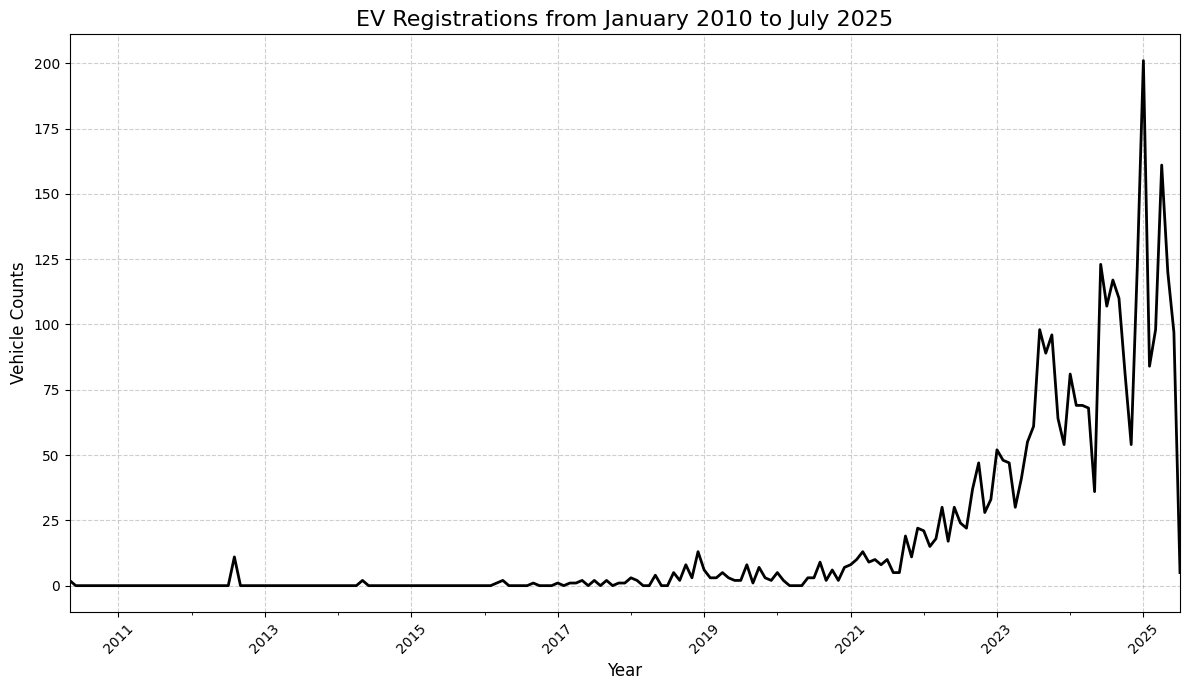

In [38]:
# Make a copy to avoid modifying the original dataframe
df = ev_arima_ts.copy()

# Convert 'Registration Date' to datetime objects
#df['Registration Date'] = pd.to_datetime(df['Registration Date'])

# Set 'Registration Date' as the index for resampling
#df.set_index('Registration Date', inplace=True)

# Resample the data to a monthly frequency and sum the vehicle count
monthly_vehicle_count = df['Vehicle Count'].resample('MS').sum()

# Create the plot
plt.figure(figsize=(12, 7))
monthly_vehicle_count.plot(kind='line', color='black', linewidth=2)

# Add titles and labels
plt.title('EV Registrations from January 2010 to July 2025', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Vehicle Counts', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Customize the x-axis to show years more clearly
plt.xticks(rotation=45)
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping

# Display the plot
plt.show()

## Split DATA

- Our goal is to predict future values in the time series (August 2025 - July 2026).
- To do this, we'll use data from August 2022 through July 2024 for training the model.
- We'll then use data August 2024 through July 2025 for testing the predictions.

In [40]:
trn = df.loc[(df.index > '2022-08-01') & (df.index < '2024-07-01')]

- Plot the training data.

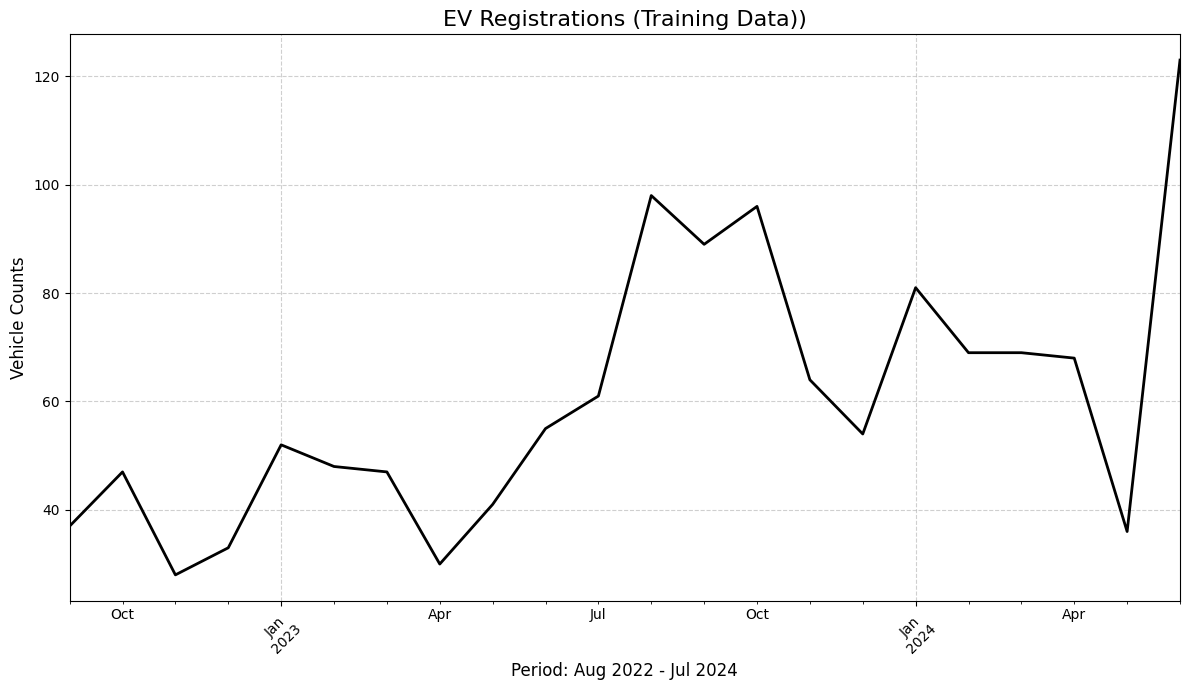

In [41]:
# Resample the data to a monthly frequency and sum the vehicle count
trained_vehicle_count = trn['Vehicle Count'].resample('MS').sum()

# Create the plot
plt.figure(figsize=(12, 7))
trained_vehicle_count.plot(kind='line', color='black', linewidth=2)

# Add titles and labels
plt.title('EV Registrations (Training Data)', fontsize=16)
plt.xlabel('Period: Aug 2022 - Jul 2024', fontsize=12)
plt.ylabel('Vehicle Counts', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Customize the x-axis to show years more clearly
plt.xticks(rotation=45)
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping

# Display the plot
plt.show()

## Create Testing Dataset

- Use data from Aug 2024 through July 2025 (the 12 months) for testing.

In [42]:
tst = df.loc[(df.index > '2024-08-01') & (df.index < '2025-07-01')]

- Plot the testing data.
- Note that the vertical scale changes from the previous graph.

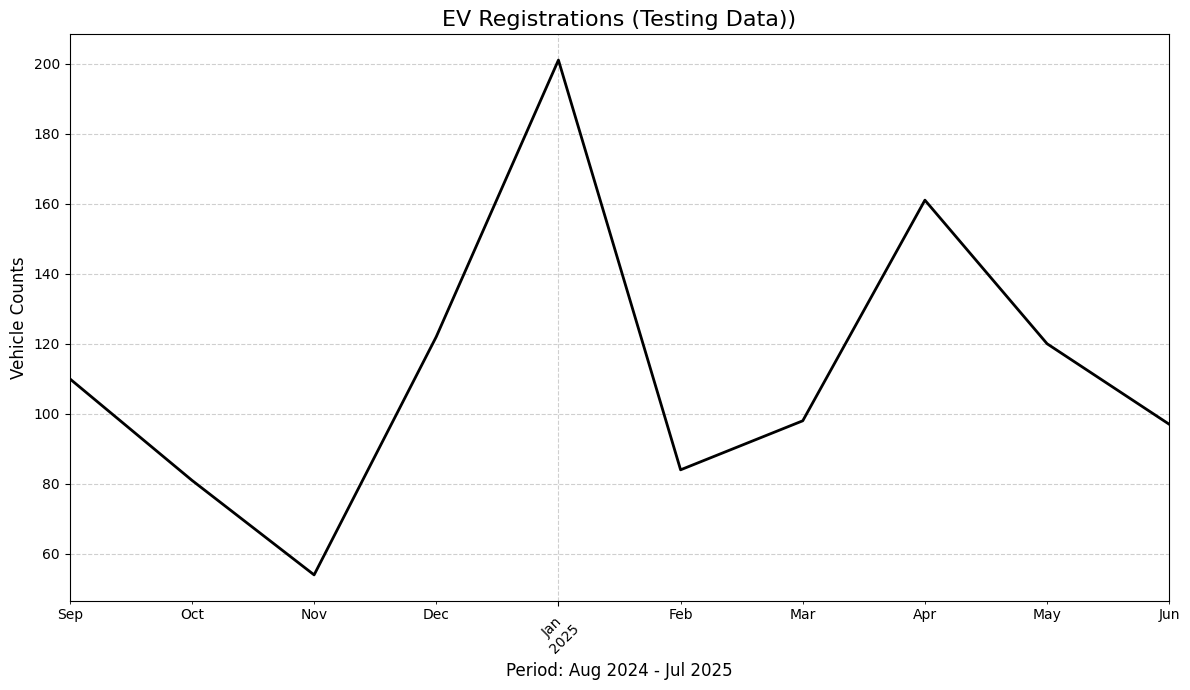

In [43]:
# Resample the data to a monthly frequency and sum the vehicle count
tested_vehicle_count = tst['Vehicle Count'].resample('MS').sum()

# Create the plot
plt.figure(figsize=(12, 7))
tested_vehicle_count.plot(kind='line', color='black', linewidth=2)

# Add titles and labels
plt.title('EV Registrations (Testing Data))', fontsize=16)
plt.xlabel('Period: Aug 2024 - Jul 2025', fontsize=12)
plt.ylabel('Vehicle Counts', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Customize the x-axis to show years more clearly
plt.xticks(rotation=45)
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping

# Display the plot
plt.show()

## Prepare MODEL

### Test Stationarity

ARIMA requires non-stationary data. That is, ARIMA needs data where the mean, the variance, and/or the covariance vary over time. Non-stationary data shows significant correlations when lagged. A "correlogram" graph (or ACF plot) shows the degree of correlation at different values of lag. Ideally, none of the lag values will fall in the range of nonsignificant correlations.

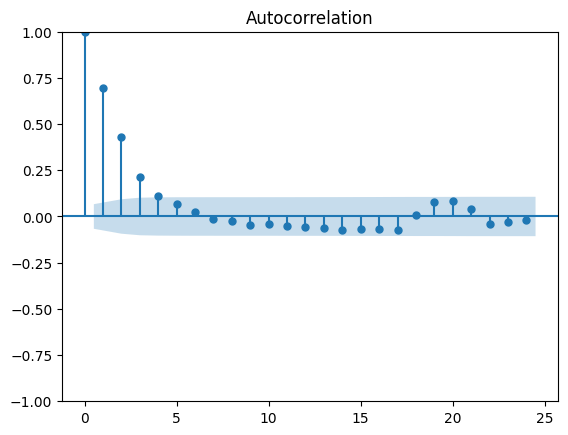

In [45]:
# Select the 'Vehicle Count' column and pass it to the function
trn_acf = plot_acf(trn['Vehicle Count'], lags=24)

## Linear Model

- Fit a linear regression model to serve as a baseline.
- The dependent (or endogenous) variable is the number of passengers.
- The independent (or exogenous) variable is a linear time trend, including a constant (or intercept).

In [46]:
lr = sm.OLS(endog=trn['Vehicle Count'], exog=sm.add_constant(np.arange(1, 1 + trn.shape[0]))).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:          Vehicle Count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5057
Date:                Mon, 04 Aug 2025   Prob (F-statistic):              0.477
Time:                        17:29:45   Log-Likelihood:                -1620.4
No. Observations:                 867   AIC:                             3245.
Df Residuals:                     865   BIC:                             3254.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5952      0.107     14.943      0.0

- Extract the fitted values.

In [47]:
y_hat = lr.fittedvalues

- Extract the 95% prediction interval.

In [48]:
y_ci = lr.get_prediction().conf_int(alpha=0.05)

- Graph time series with linear regression line and corresponding 95% prediction interval.

In [63]:
# Step 1: Group the data by 'ZIP Code' and resample to monthly frequency, summing the vehicle counts
monthly_counts = trn.groupby('ZIP Code')['Vehicle Count'].resample('MS').sum()
monthly_counts = monthly_counts.reset_index()

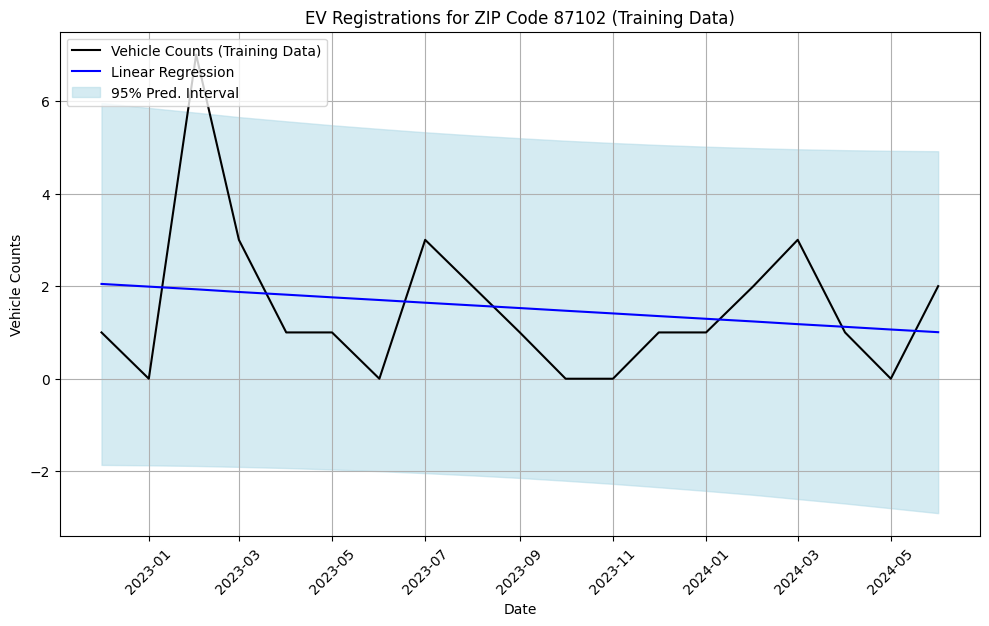

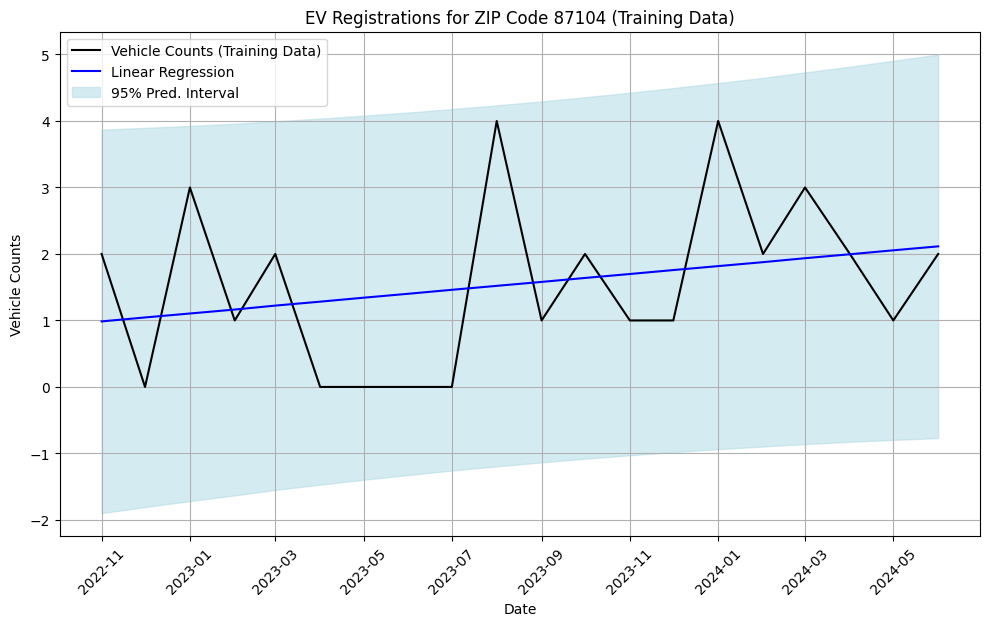

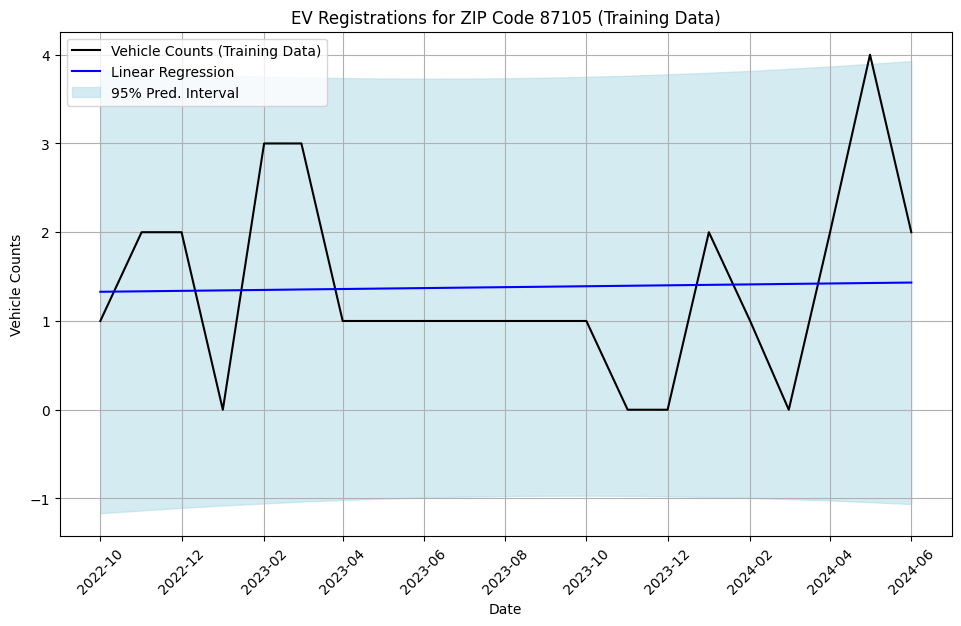

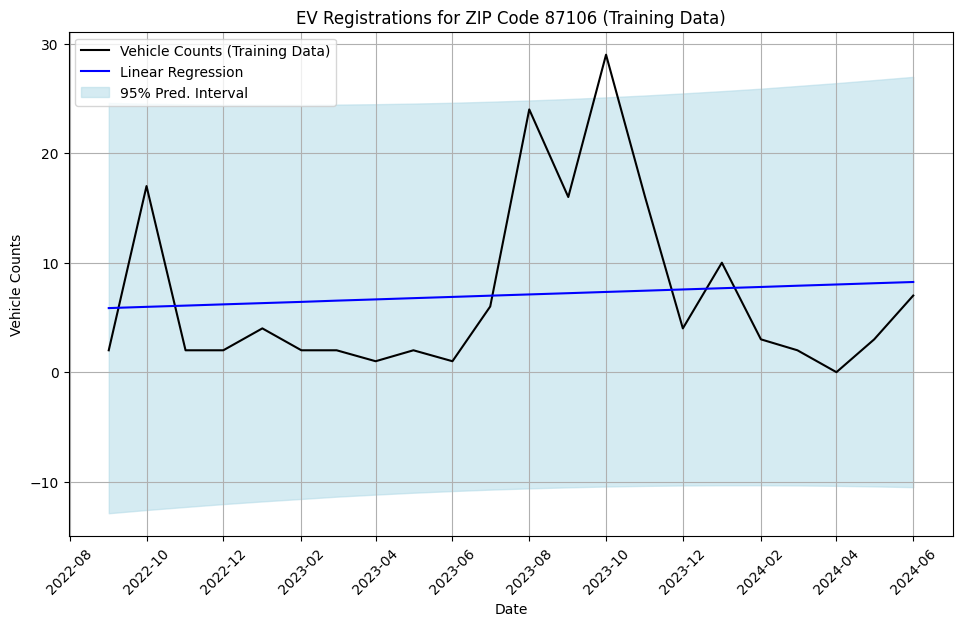

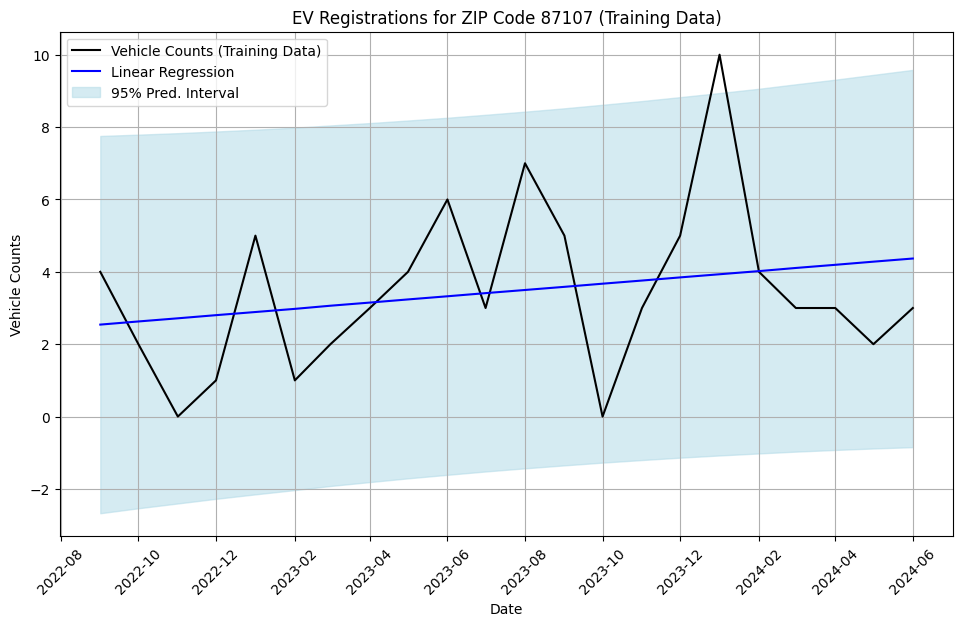

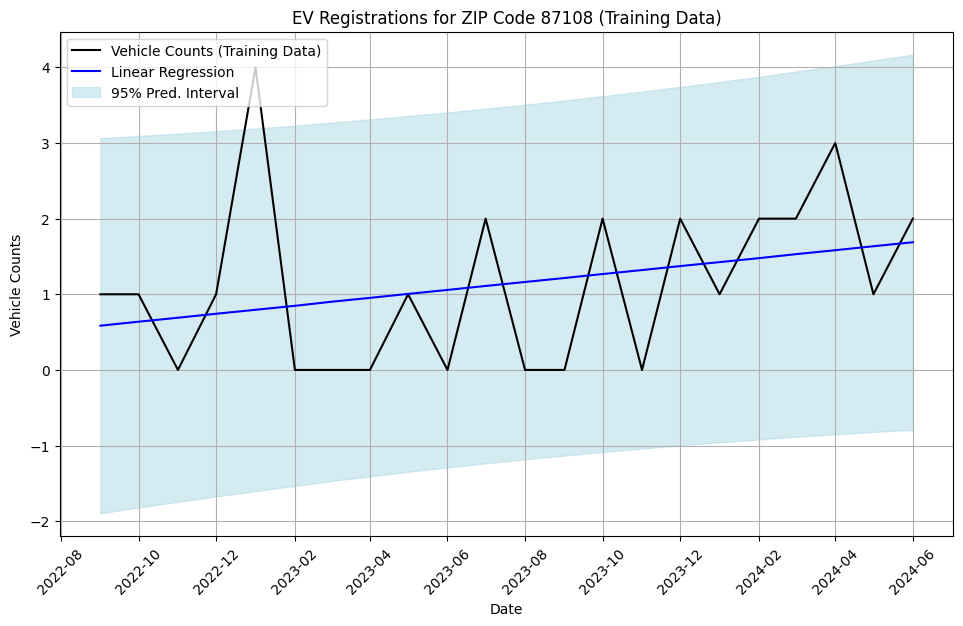

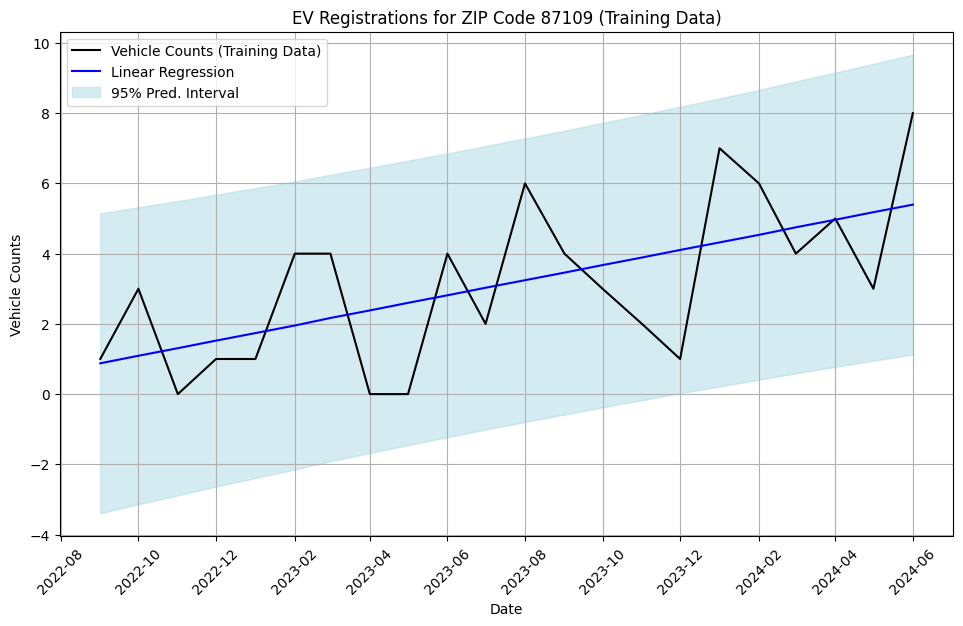

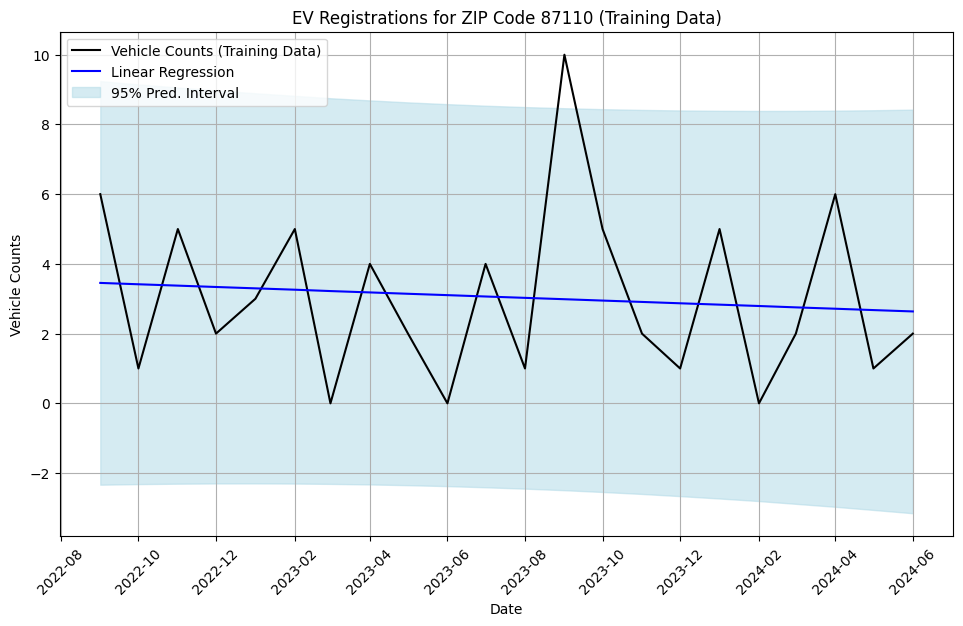

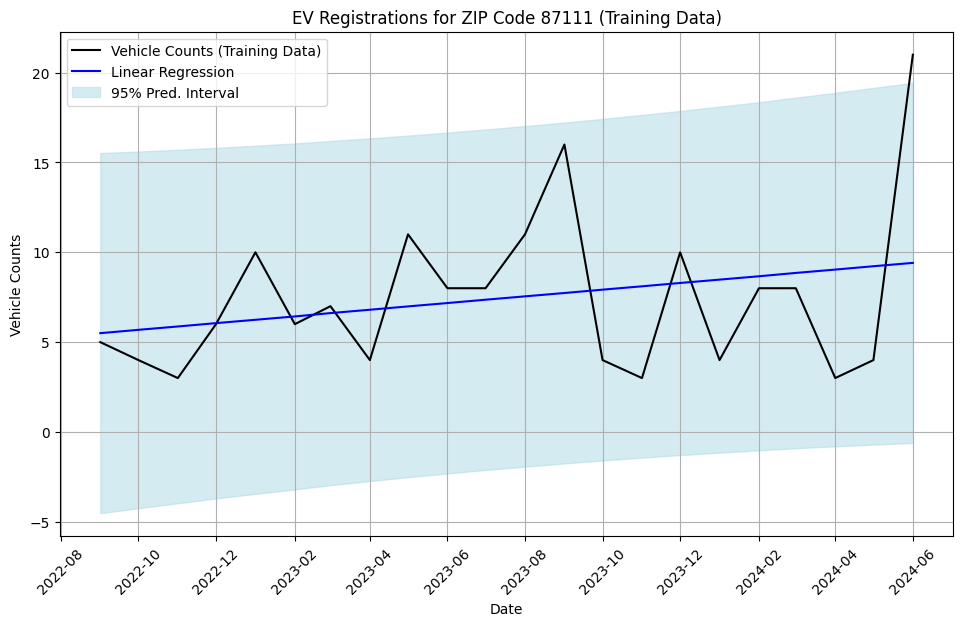

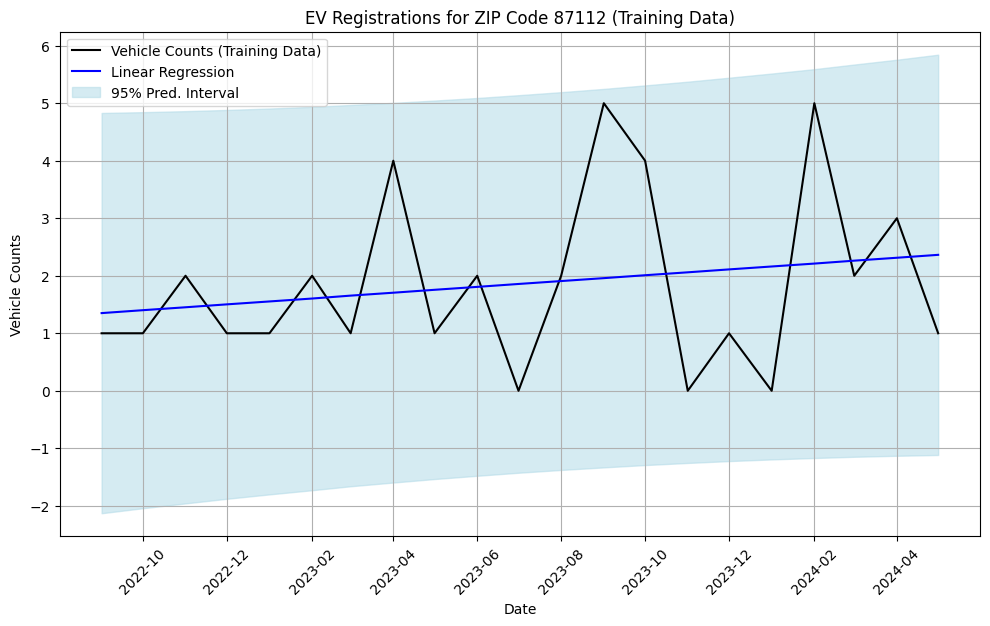

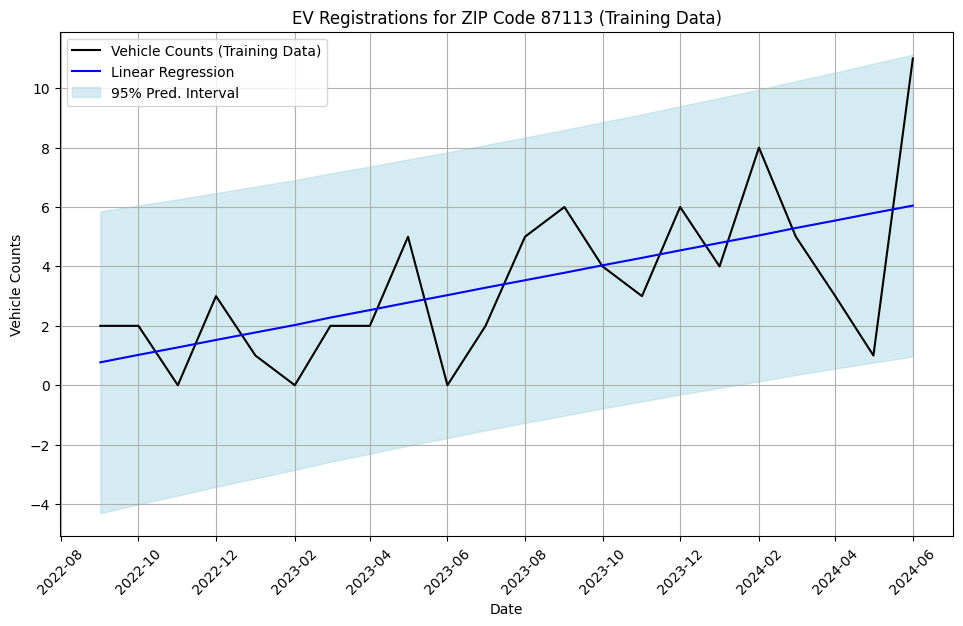

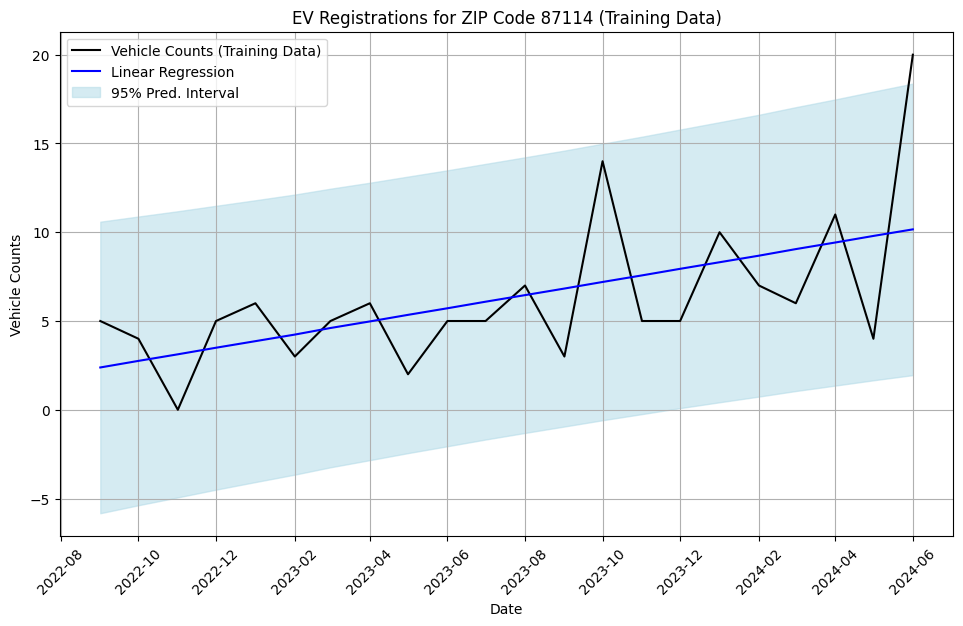

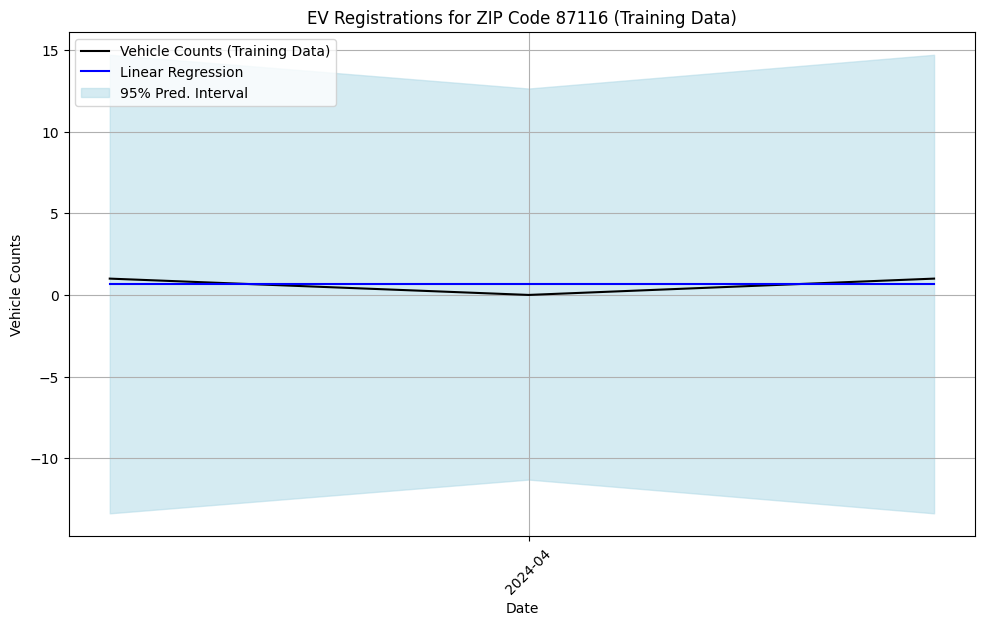

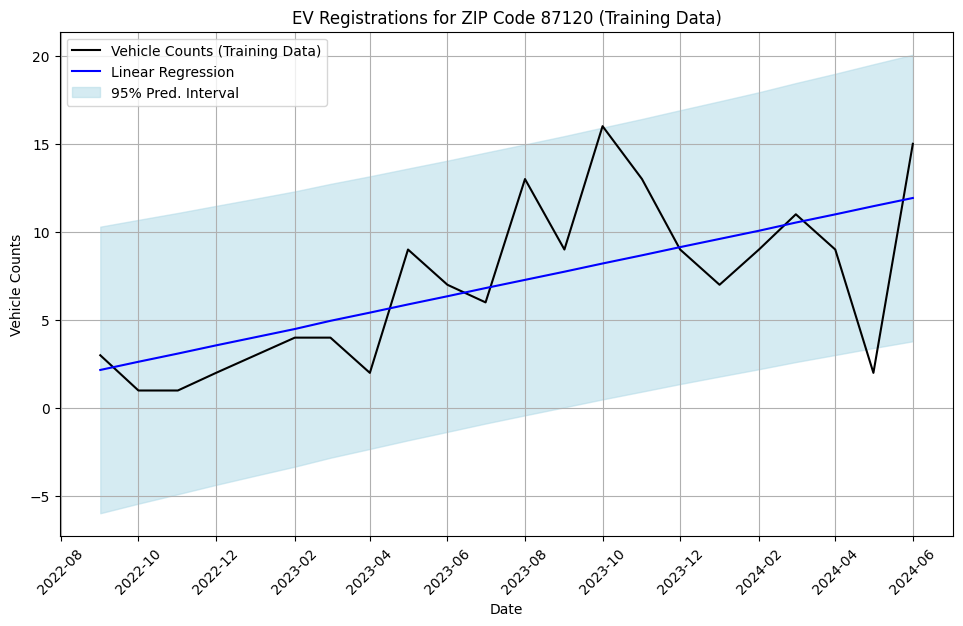

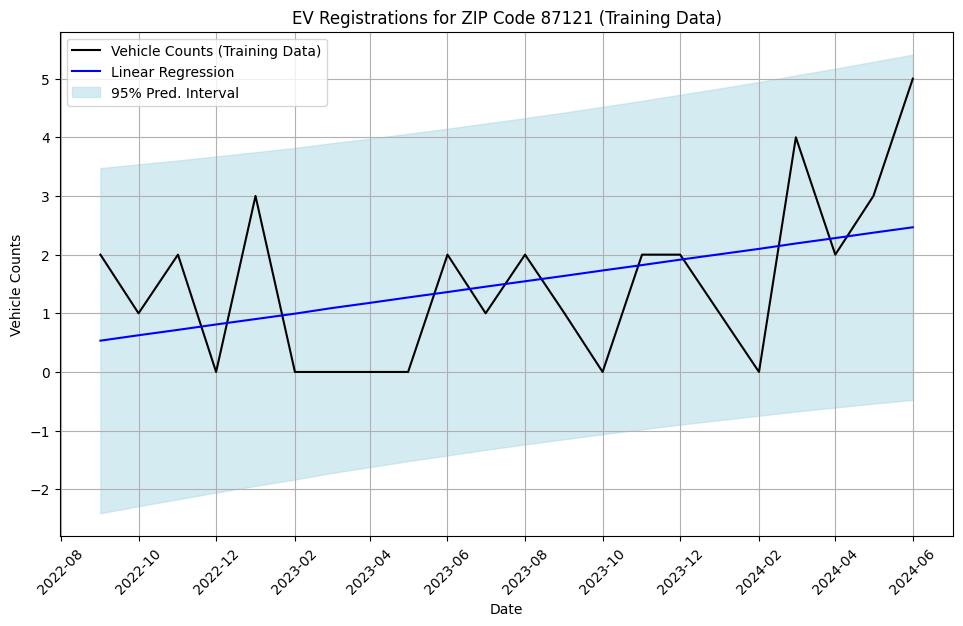

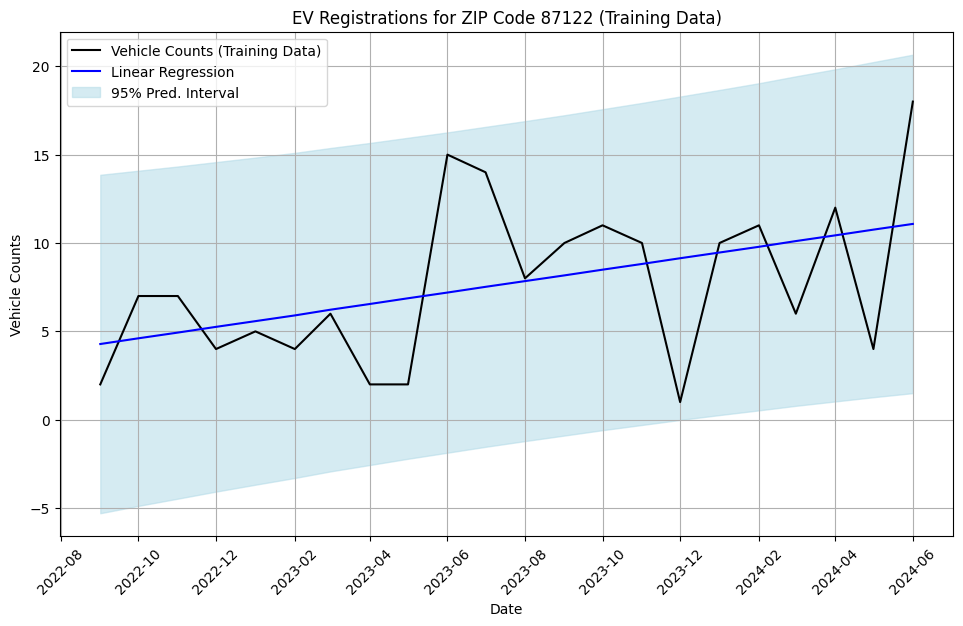

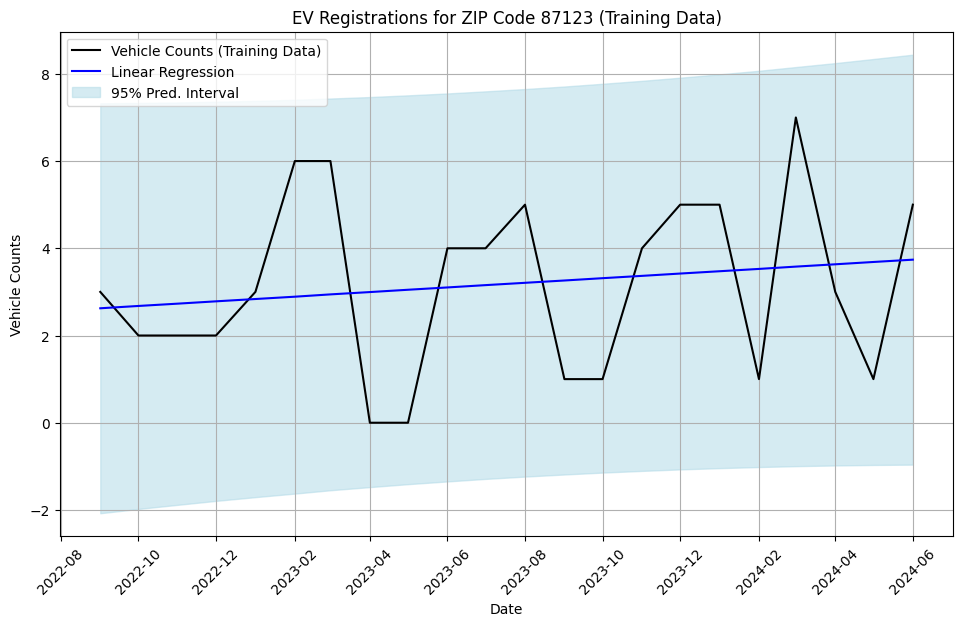

In [54]:
# Step 2: Iterate through each unique ZIP code
for zip_code in monthly_counts['ZIP Code'].unique():
    # Filter the data for the current ZIP code
    zip_data = monthly_counts[monthly_counts['ZIP Code'] == zip_code].set_index('Registration Date')

    # Create a numerical representation of time for the regression model
    x = np.arange(len(zip_data.index))
    y = zip_data['Vehicle Count'].values

    # Step 3: Fit a linear regression model
    X = sm.add_constant(x) # Add a constant term to the model
    model = sm.OLS(y, X).fit()

    # Step 4: Calculate the fitted values and prediction intervals
    y_hat = model.predict(X)
    pred_interval = model.get_prediction(X).summary_frame(alpha=0.05)
    y_ci = pred_interval[['obs_ci_lower', 'obs_ci_upper']]

    # Step 5: Plot the results
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the original data
    plt.plot(zip_data.index, y, color='black', label='Vehicle Counts (Training Data)')

    # Plot the linear regression line
    plt.plot(zip_data.index, y_hat, color='blue', label='Linear Regression')

    # Plot the 95% prediction interval
    plt.fill_between(zip_data.index, y_ci['obs_ci_lower'], y_ci['obs_ci_upper'],
                     color='lightblue', alpha=0.5, label='95% Pred. Interval')

    # Add titles and labels
    plt.xlabel('Date')
    plt.ylabel('Vehicle Counts')
    plt.title(f'EV Registrations for ZIP Code {zip_code} (Training Data)')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()

    # Use a more appropriate date formatter for the x-axis
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=2)) # Show every 2 months for readability
    plt.xticks(rotation=45)

    plt.show()


## ARIMA Train Model

- Find the best ARIMA order using the auto_arima function in the pmdarima package.

Note that the auto_arima function assumes that the time series is non-seasonal by default (i.e. the seasonal period "m" is set equal to 1 by default).

- In what follows we set "m" equal to 12 to ensure that the selected optimal model takes into account the annual seasonality observed in the time series (one cycle every 12 months).

In [58]:
# Resample the data to a monthly frequency and sum the vehicle count
# The .groupby() and .resample() combination creates a time series for each group
monthly_counts = trn.groupby('ZIP Code')['Vehicle Count'].resample('MS').sum()

In [59]:
# Step 2: Loop through each unique ZIP code
for zip_code in trn['ZIP Code'].unique():
    print(f"\n--- Finding the best ARIMA model for ZIP Code: {zip_code} ---")

    # Step 3: Extract the time series for the current ZIP code
    zip_series = monthly_counts.loc[zip_code]

    # Step 4: Train the auto_arima model
    # The 'seasonal' parameter is set to False to fix the ValueError
    auto_arima_model = auto_arima(zip_series, m=12, with_intercept=False,
                                     seasonal=False, # For non-seasonal data
                                     suppress_warnings=True, stepwise=True)

    # Step 5: Print the summary of the best model found
    print(auto_arima_model.summary())


--- Finding the best ARIMA model for ZIP Code: 87102 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:                        SARIMAX   Log Likelihood                 -36.291
Date:                Mon, 04 Aug 2025   AIC                             76.582
Time:                        18:09:02   BIC                             78.471
Sample:                    12-01-2022   HQIC                            76.901
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5263      0.585      2.608      0.009       0.379       2.673
sigma2         2.6704      0.785      3.401      0.001       1.131       4.209
Ljung-Box (L1) (Q):                   0.08   Jarque-

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   20
Model:               SARIMAX(0, 0, 3)   Log Likelihood                 -29.904
Date:                Mon, 04 Aug 2025   AIC                             69.808
Time:                        18:09:03   BIC                             74.786
Sample:                    11-01-2022   HQIC                            70.779
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4934      0.394      3.793      0.000       0.722       2.265
ma.L1          0.0327      0.282      0.116      0.908      -0.520       0.585
ma.L2          0.5745      0.323      1.777      0.0

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 -29.257
Date:                Mon, 04 Aug 2025   AIC                             64.514
Time:                        18:09:04   BIC                             67.648
Sample:                    10-01-2022   HQIC                            65.194
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3604      0.468      2.905      0.004       0.443       2.278
ma.L1          0.6711      0.282      2.382      0.017       0.119       1.223
sigma2         0.9231      0.339      2.723      0.0

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -74.249
Date:                Mon, 04 Aug 2025   AIC                            154.499
Time:                        18:09:06   BIC                            157.772
Sample:                    09-01-2022   HQIC                           155.270
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.7741      3.509      1.076      0.282      -3.104      10.652
ar.L1          0.4505      0.249      1.807      0.071      -0.038       0.939
sigma2        49.4893     19.157      2.583      0.0

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:                        SARIMAX   Log Likelihood                 -49.261
Date:                Mon, 04 Aug 2025   AIC                            102.521
Time:                        18:09:07   BIC                            104.703
Sample:                    09-01-2022   HQIC                           103.035
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4545      0.561      6.153      0.000       2.354       4.555
sigma2         5.1570      1.438      3.586      0.000       2.338       7.976
Ljung-Box (L1) (Q):                   1.10   Jarque-

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:                        SARIMAX   Log Likelihood                 -33.301
Date:                Mon, 04 Aug 2025   AIC                             70.603
Time:                        18:09:08   BIC                             72.785
Sample:                    09-01-2022   HQIC                            71.117
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1364      0.278      4.094      0.000       0.592       1.680
sigma2         1.2087      0.433      2.792      0.005       0.360       2.057
Ljung-Box (L1) (Q):                   0.19   Jarque-

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -46.799
Date:                Mon, 04 Aug 2025   AIC                             97.597
Time:                        18:09:09   BIC                             99.686
Sample:                    09-01-2022   HQIC                            98.051
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7426      0.270     -2.747      0.006      -1.272      -0.213
sigma2         4.8596      1.789      2.717      0.007       1.354       8.365
Ljung-Box (L1) (Q):                   0.18   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 -49.805
Date:                Mon, 04 Aug 2025   AIC                            105.609
Time:                        18:09:10   BIC                            108.882
Sample:                    09-01-2022   HQIC                           106.380
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0287      0.386      7.841      0.000       2.272       3.786
ma.L1         -0.3956      0.177     -2.237      0.025      -0.742      -0.049
sigma2         5.3766      1.920      2.801      0.0

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -66.361
Date:                Mon, 04 Aug 2025   AIC                            138.722
Time:                        18:09:11   BIC                            141.996
Sample:                    09-01-2022   HQIC                           139.494
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.009    110.693      0.000       0.982       1.018
ma.L1         -0.9713      0.801     -1.213      0.225      -2.541       0.598
sigma2        20.7888     14.209      1.463      0.1

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   21
Model:                        SARIMAX   Log Likelihood                 -38.161
Date:                Mon, 04 Aug 2025   AIC                             80.321
Time:                        18:09:12   BIC                             82.410
Sample:                    09-01-2022   HQIC                            80.775
                         - 05-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.8571      0.429      4.331      0.000       1.017       2.698
sigma2         2.2177      0.979      2.265      0.024       0.299       4.137
Ljung-Box (L1) (Q):                   0.11   Jarque-

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -50.315
Date:                Mon, 04 Aug 2025   AIC                            104.629
Time:                        18:09:13   BIC                            106.718
Sample:                    09-01-2022   HQIC                           105.083
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7507      0.245     -3.063      0.002      -1.231      -0.270
sigma2         6.7837      1.887      3.596      0.000       3.086      10.481
Ljung-Box (L1) (Q):                   0.84   Jarque-

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 -57.411
Date:                Mon, 04 Aug 2025   AIC                            120.821
Time:                        18:09:15   BIC                            123.955
Sample:                    09-01-2022   HQIC                           121.501
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5593      0.187     -8.360      0.000      -1.925      -1.194
ma.L2          0.7788      0.248      3.146      0.002       0.294       1.264
sigma2        11.8422      3.923      3.019      0.0

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    3
Model:                        SARIMAX   Log Likelihood                  -2.001
Date:                Mon, 04 Aug 2025   AIC                              8.001
Time:                        18:09:16   BIC                              6.199
Sample:                    03-01-2024   HQIC                             4.378
                         - 05-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6667      0.174      3.827      0.000       0.325       1.008
sigma2         0.2222      0.131      1.701      0.089      -0.034       0.478
Ljung-Box (L1) (Q):                   3.33   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -58.399
Date:                Mon, 04 Aug 2025   AIC                            120.798
Time:                        18:09:17   BIC                            122.887
Sample:                    09-01-2022   HQIC                           121.252
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5875      0.179     -3.286      0.001      -0.938      -0.237
sigma2        14.9361      4.444      3.361      0.001       6.226      23.646
Ljung-Box (L1) (Q):                   0.54   Jarque-

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:                        SARIMAX   Log Likelihood                 -38.198
Date:                Mon, 04 Aug 2025   AIC                             80.396
Time:                        18:09:20   BIC                             82.578
Sample:                    09-01-2022   HQIC                            80.910
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5000      0.343      4.375      0.000       0.828       2.172
sigma2         1.8864      0.665      2.837      0.005       0.583       3.189
Ljung-Box (L1) (Q):                   0.21   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:                        SARIMAX   Log Likelihood                 -64.484
Date:                Mon, 04 Aug 2025   AIC                            132.969
Time:                        18:09:21   BIC                            135.151
Sample:                    09-01-2022   HQIC                           133.483
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.6818      1.043      7.363      0.000       5.637       9.727
sigma2        20.5806      8.047      2.558      0.011       4.809      36.353
Ljung-Box (L1) (Q):                   0.01   Jarque-

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:                        SARIMAX   Log Likelihood                 -46.624
Date:                Mon, 04 Aug 2025   AIC                             97.248
Time:                        18:09:22   BIC                             99.430
Sample:                    09-01-2022   HQIC                            97.762
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.1818      0.431      7.379      0.000       2.337       4.027
sigma2         4.0579      1.840      2.206      0.027       0.452       7.664
Ljung-Box (L1) (Q):                   0.01   Jarque-

#### Residue Test after training

First set of numbers is for the basic, non-seasonal model

  1     # p: Auto-regressive (AR) order

  1     # d: Integrate (I), or degree of differencing

  0     # q: Moving average (MA) order

- Retrieve the order set of non-seasonal model

In [62]:
from matplotlib.dates import DateFormatter, MonthLocator

In [66]:
trn_zip = trn.copy()

In [67]:
#Convert the 'ZIP Code' column to a string type
trn_zip['ZIP Code'] = trn_zip['ZIP Code'].astype(str)

monthly_counts_zip = trn_zip.groupby('ZIP Code')['Vehicle Count'].resample('MS').sum()


--- Processing data for ZIP Code: 87102 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


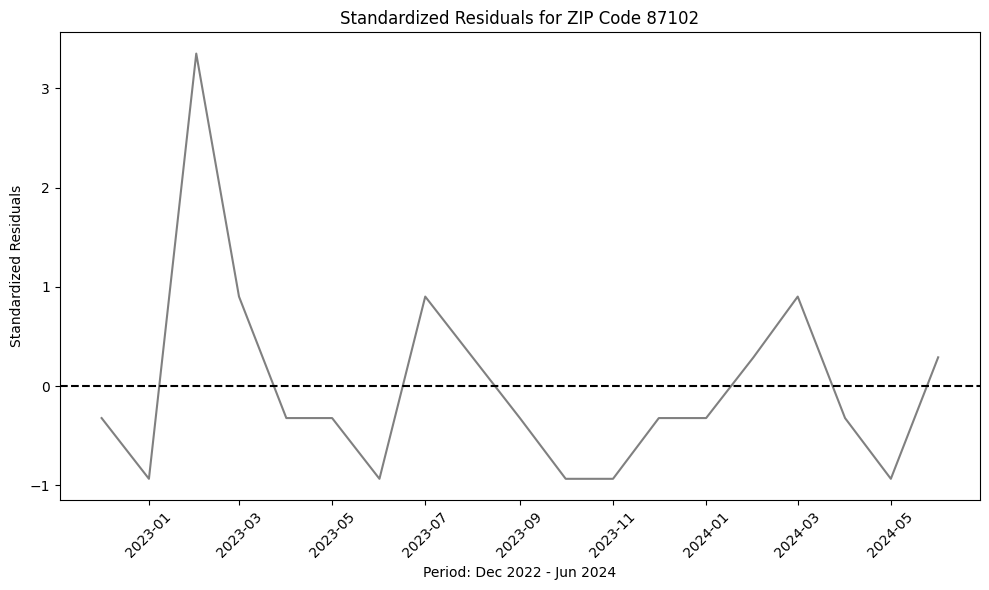


--- Processing data for ZIP Code: 87104 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 3)


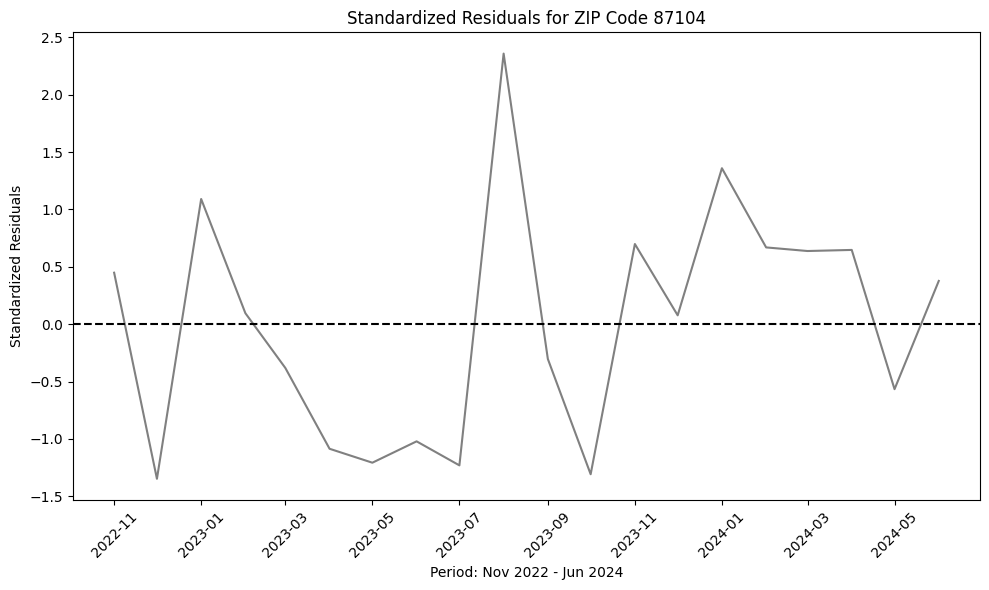


--- Processing data for ZIP Code: 87105 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 1)


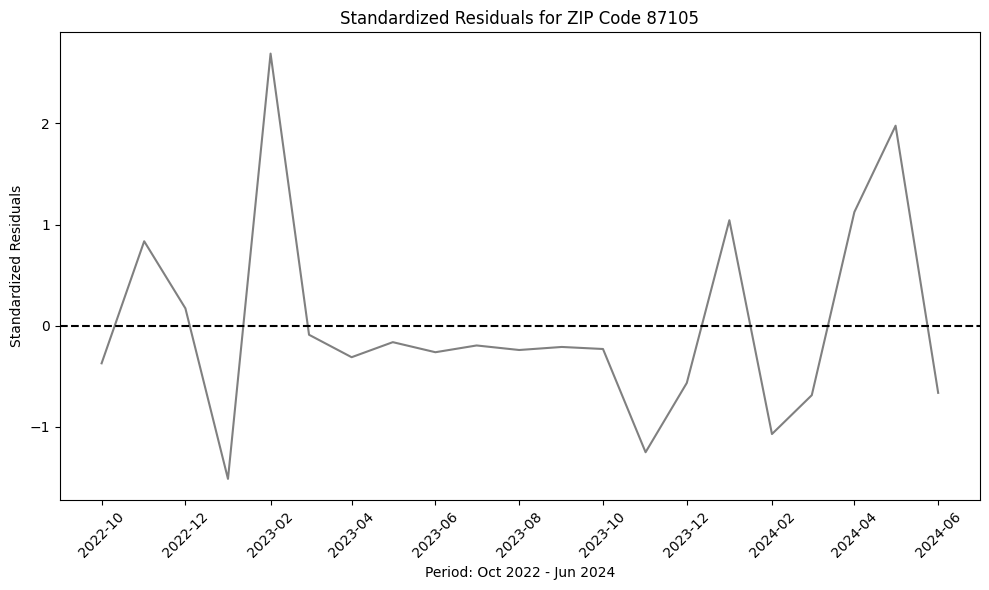


--- Processing data for ZIP Code: 87106 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (1, 0, 0)


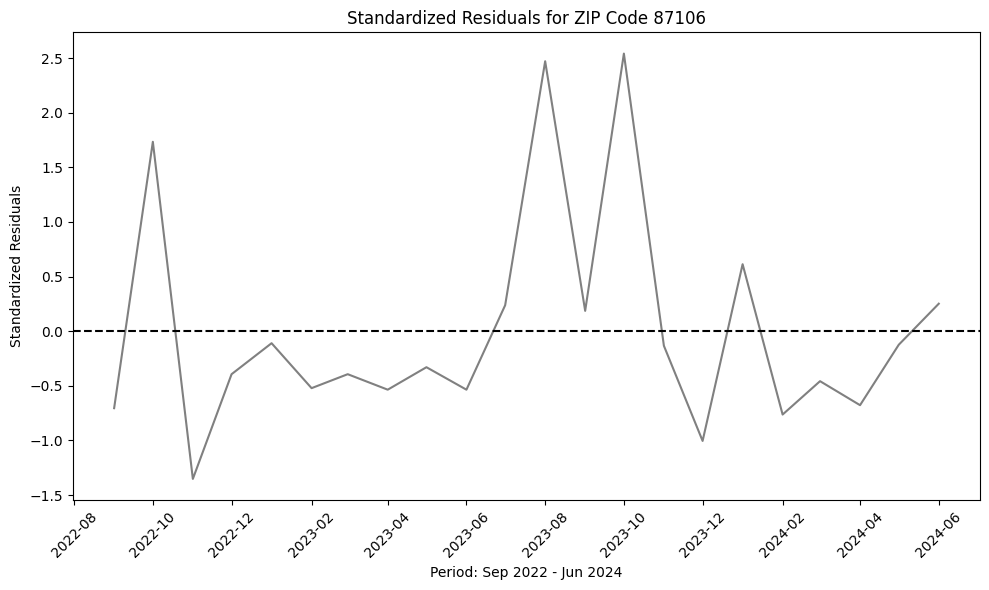


--- Processing data for ZIP Code: 87107 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


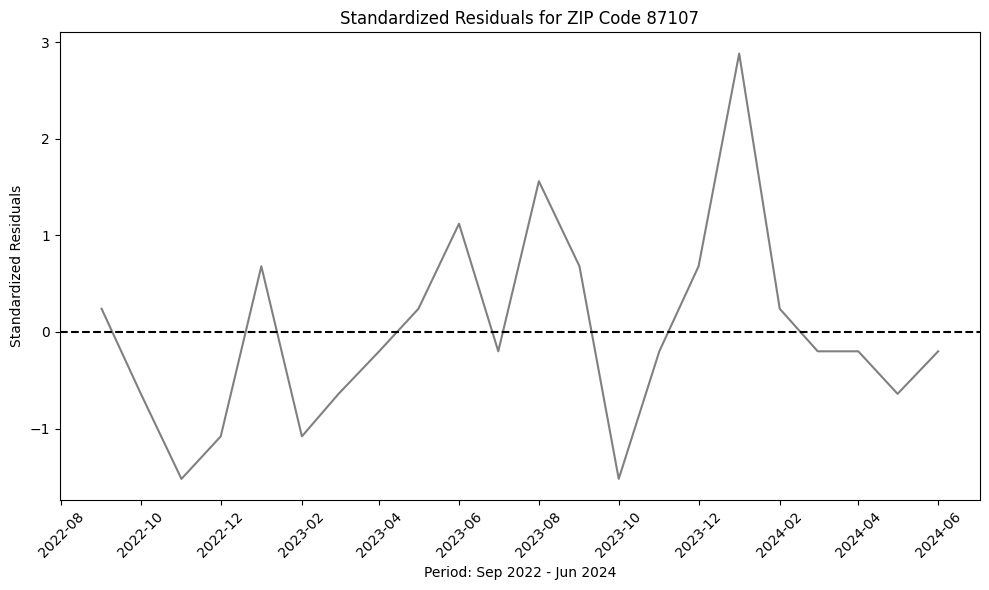


--- Processing data for ZIP Code: 87108 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


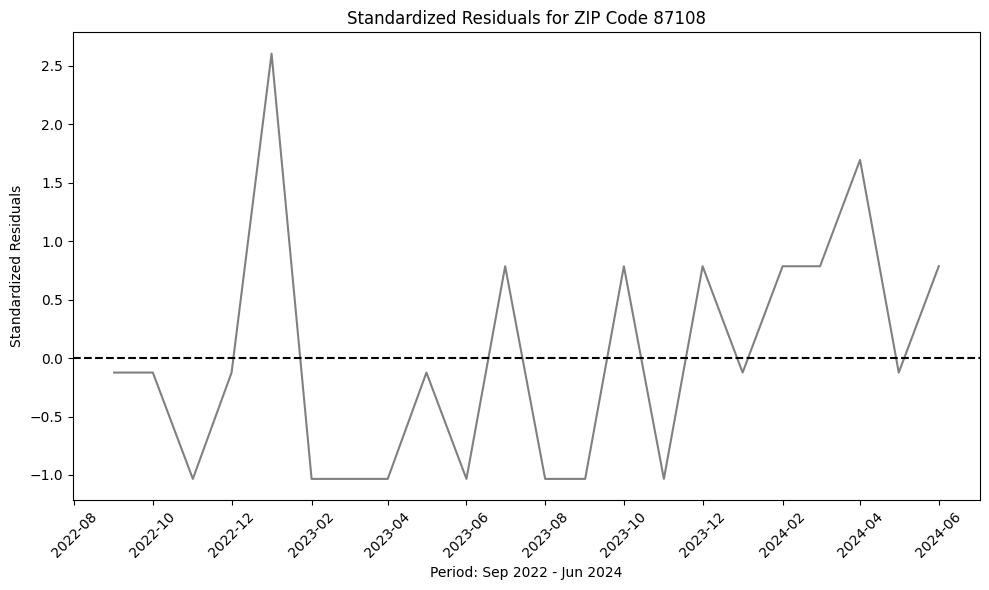


--- Processing data for ZIP Code: 87109 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 1, 1)


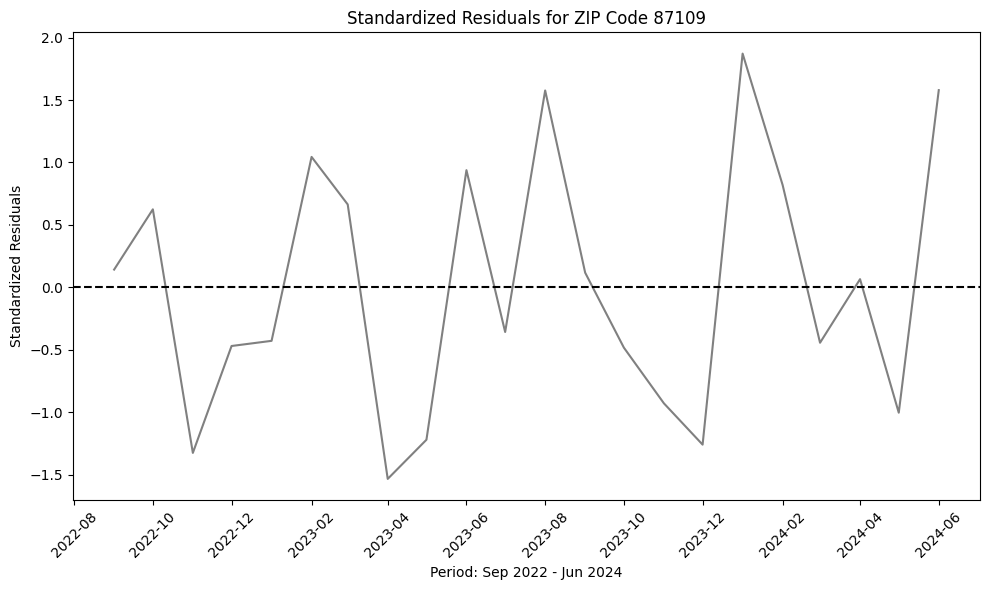


--- Processing data for ZIP Code: 87110 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 1)


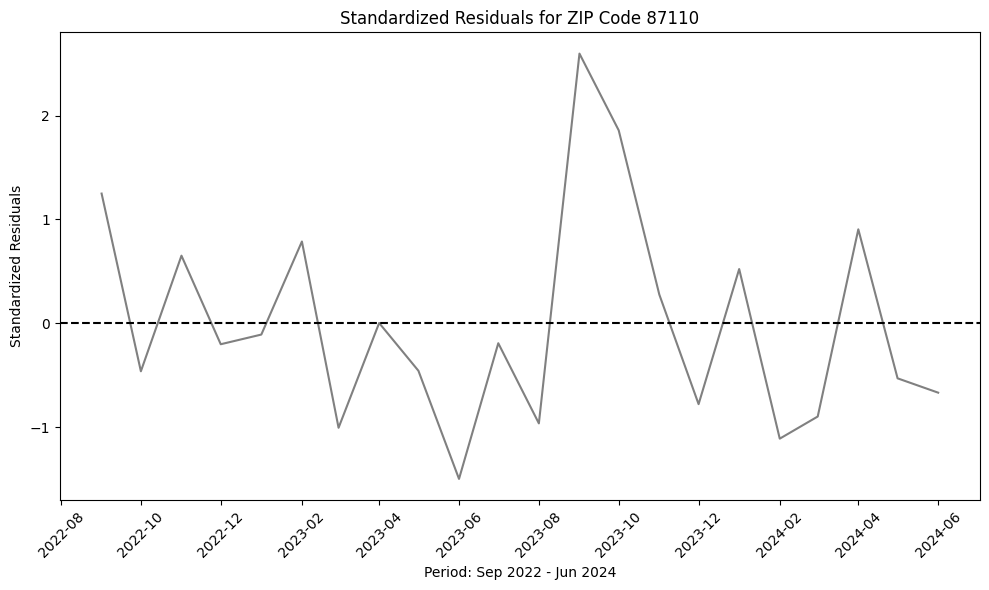


--- Processing data for ZIP Code: 87111 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (1, 0, 1)


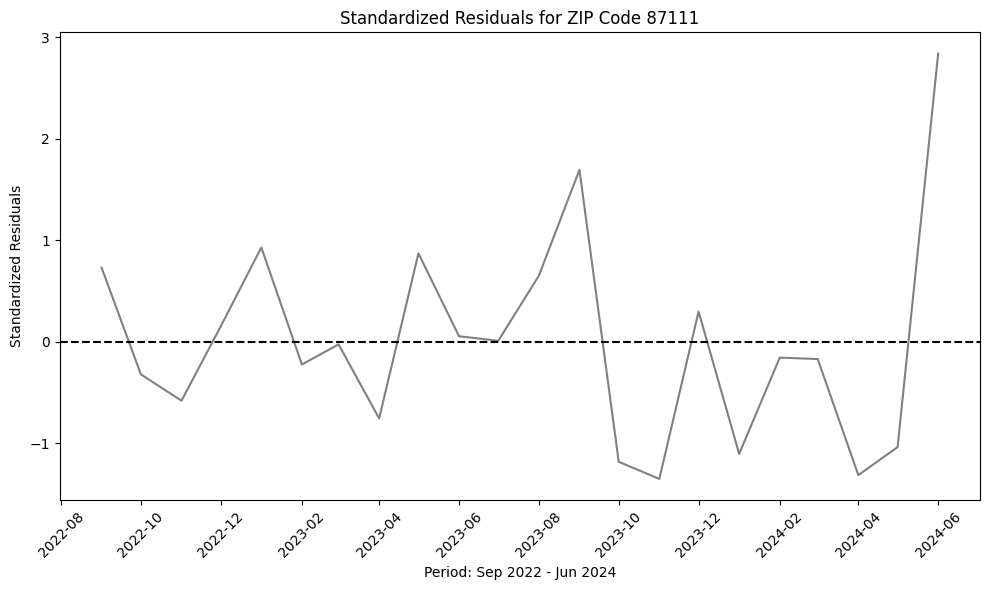


--- Processing data for ZIP Code: 87112 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


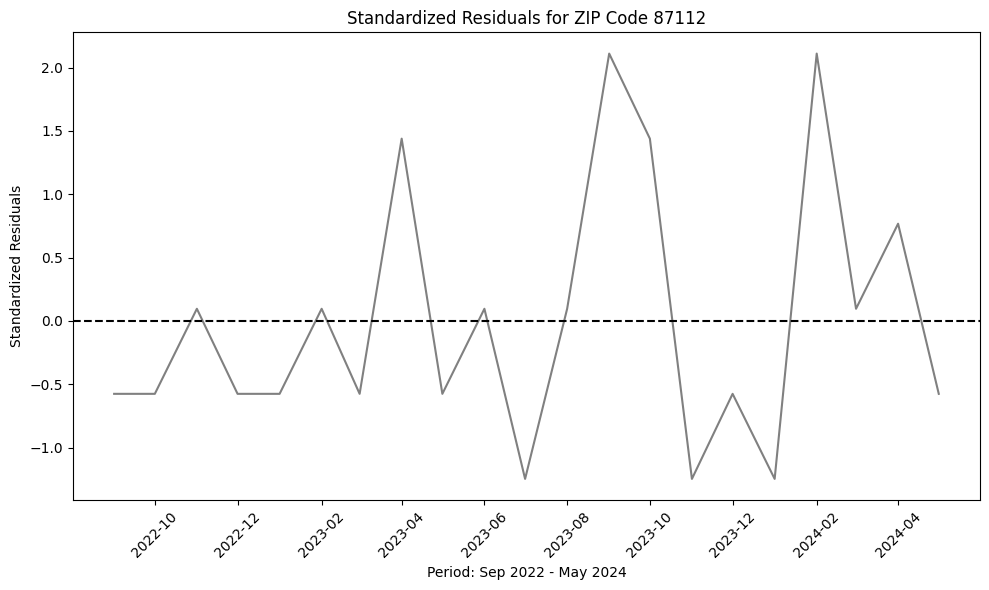


--- Processing data for ZIP Code: 87113 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 1, 1)


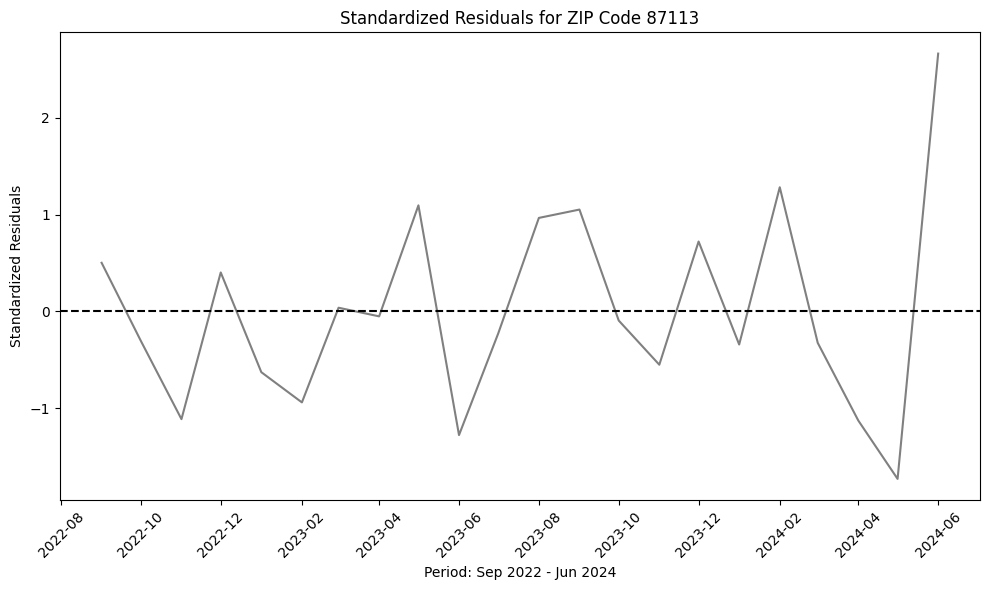


--- Processing data for ZIP Code: 87114 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 1, 2)


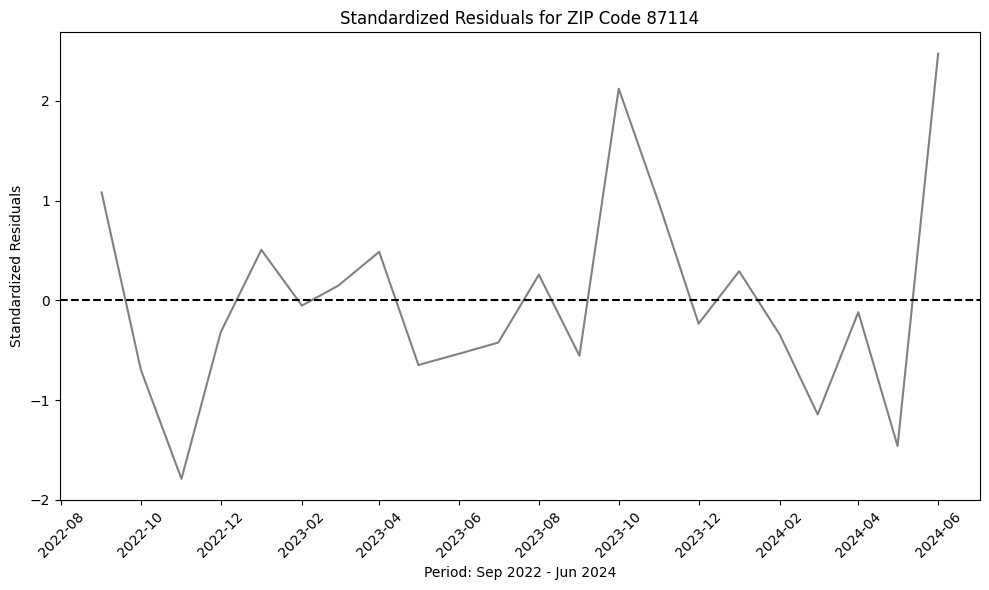


--- Processing data for ZIP Code: 87116 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


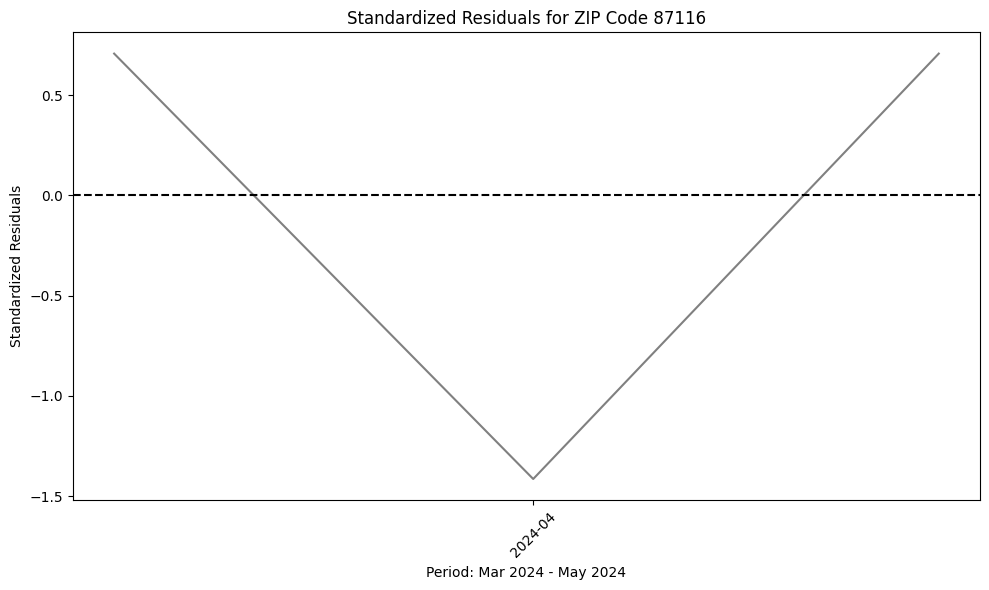


--- Processing data for ZIP Code: 87120 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 1, 1)


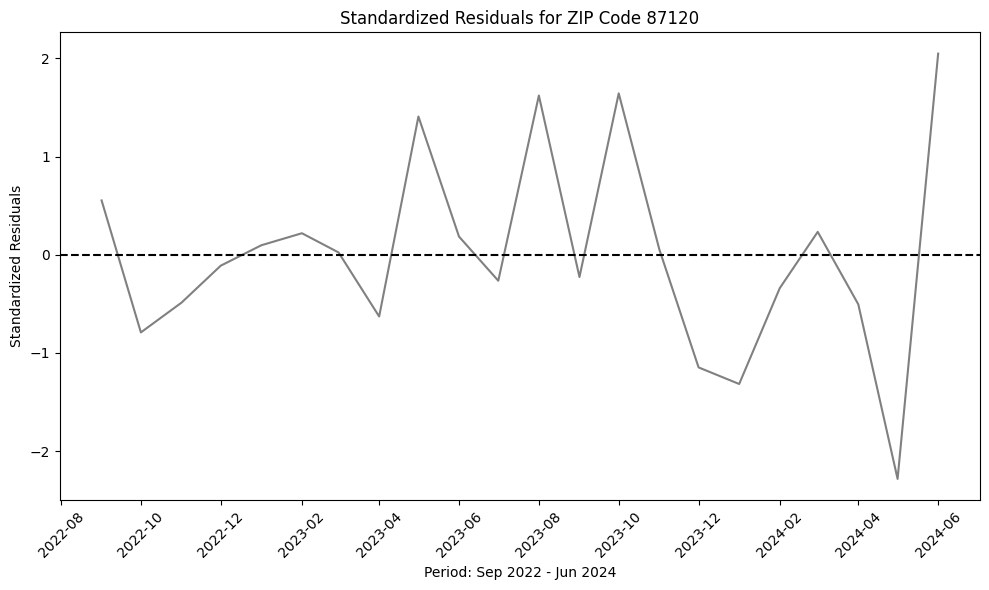


--- Processing data for ZIP Code: 87121 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


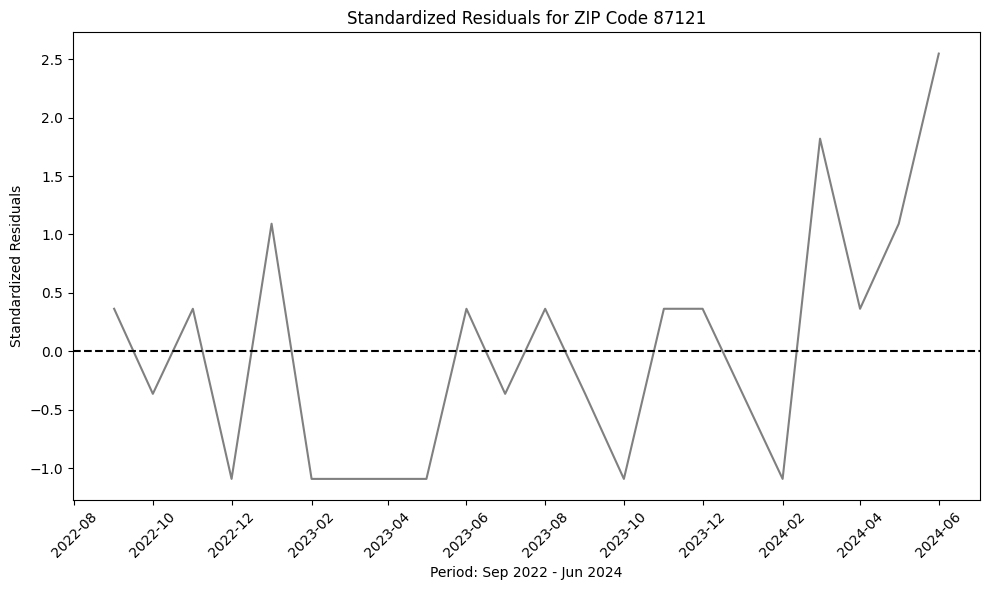


--- Processing data for ZIP Code: 87122 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


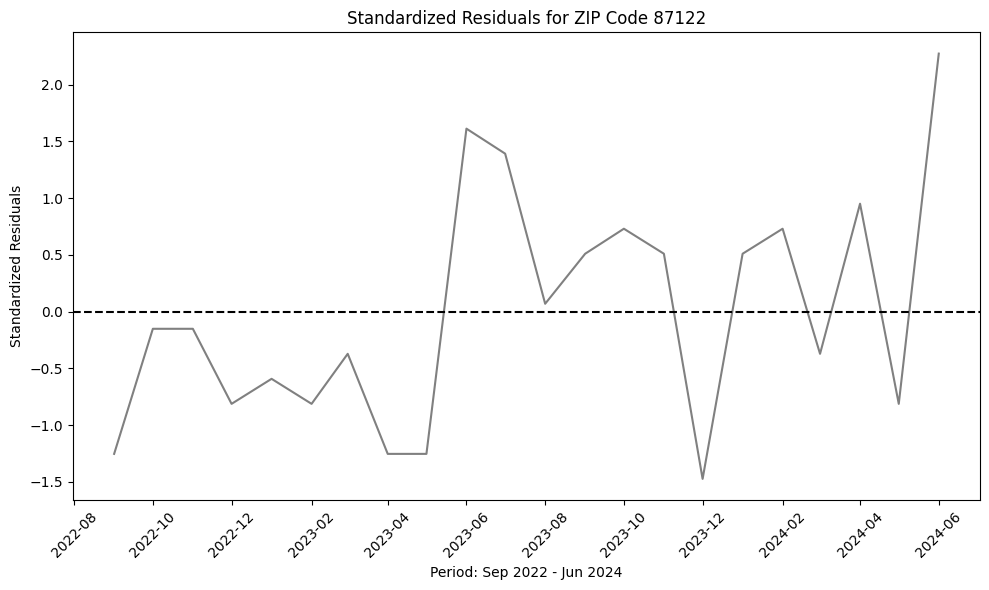


--- Processing data for ZIP Code: 87123 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


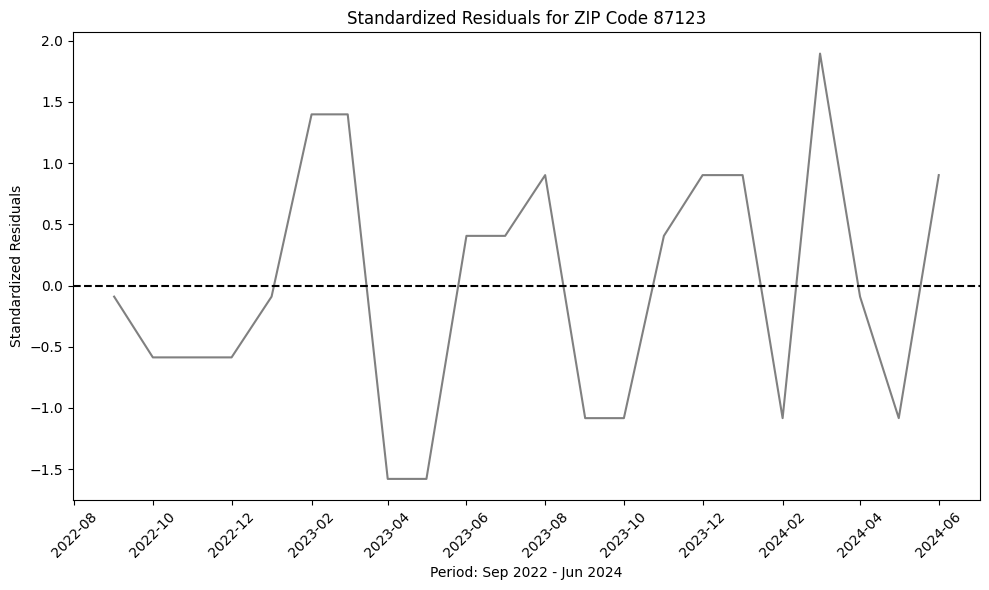

In [68]:
# Step 2: Loop through each unique ZIP code
for zip_code in trn_zip['ZIP Code'].unique():
    print(f"\n--- Processing data for ZIP Code: {zip_code} ---")

    # Step 3: Extract the time series for the current ZIP code
    zip_series_2 = monthly_counts_zip.loc[zip_code]

    # Step 4: Train the non-seasonal auto_arima model
    auto_arima_model2 = auto_arima(zip_series_2, m=12, with_intercept=False,
                                     seasonal=False,
                                     suppress_warnings=True, stepwise=True)

    # Step 5: Print the order set of the model
    print(f"Order of the non-seasonal ARIMA model: {auto_arima_model2.order}")

    # Step 6: Extract the residuals and plot them
    # Check if the model has residuals to prevent errors
    if auto_arima_model2.resid().size > 0:
        resid_zip = auto_arima_model2.resid()

        # Plot the standardized residuals.
        fig, ax = plt.subplots(figsize=(10, 6))

        # Use the index of the specific zip_series for the x-axis
        plt.plot(zip_series_2.index, stats.zscore(resid_zip), color='gray')

        plt.axhline(0, color='black', linestyle='--') # Add a zero line for reference

        # Customize the title and labels to be dynamic
        plt.title(f'Standardized Residuals for ZIP Code {zip_code}')
        plt.xlabel(f'Period: {zip_series_2.index.min().strftime("%b %Y")} - {zip_series_2.index.max().strftime("%b %Y")}')
        plt.ylabel('Standardized Residuals')

        # Set a more appropriate date formatter for monthly data
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(MonthLocator(interval=2)) # Show every 2 months
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Could not extract residuals. The model may not have been trained successfully.")

#### Autocorrection of the residues

In [69]:
from statsmodels.graphics.tsaplots import plot_acf # New import for ACF plot
from statsmodels.stats.diagnostic import acorr_ljungbox # New import for Ljung-Box test


--- Processing data for ZIP Code: 87102 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


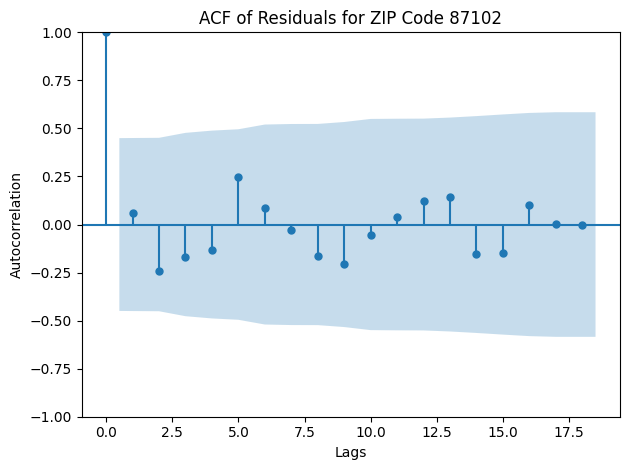

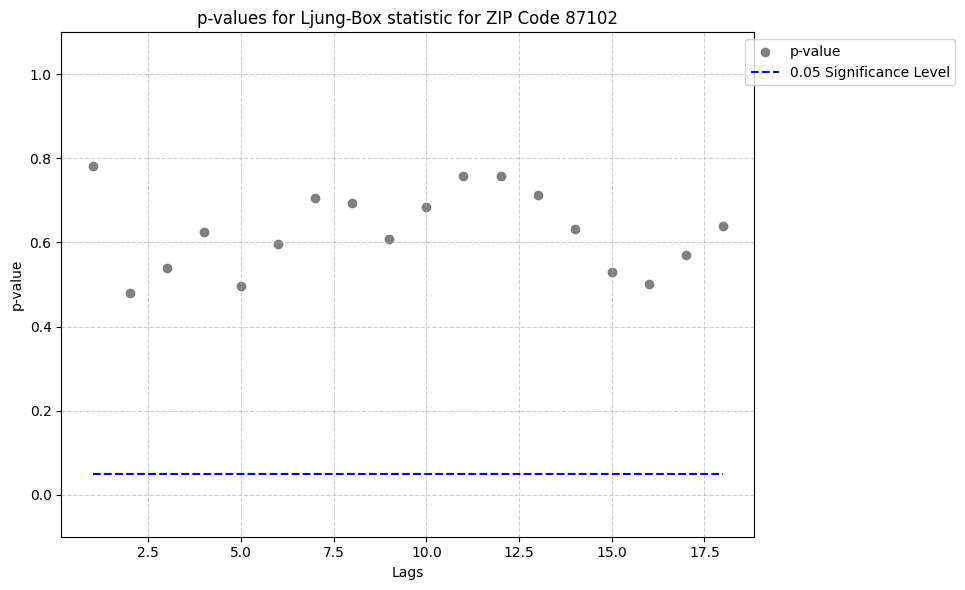


--- Processing data for ZIP Code: 87104 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 3)


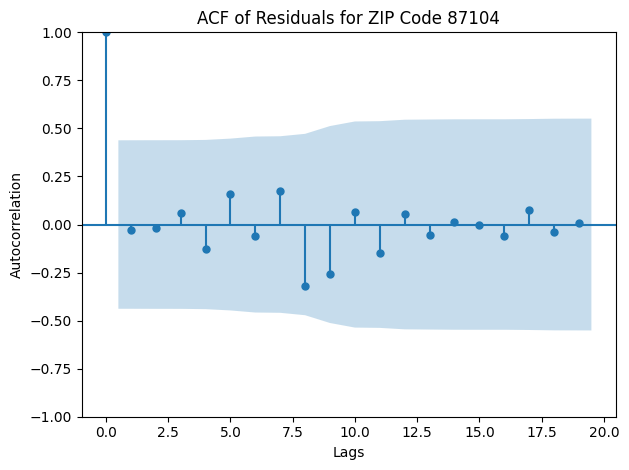

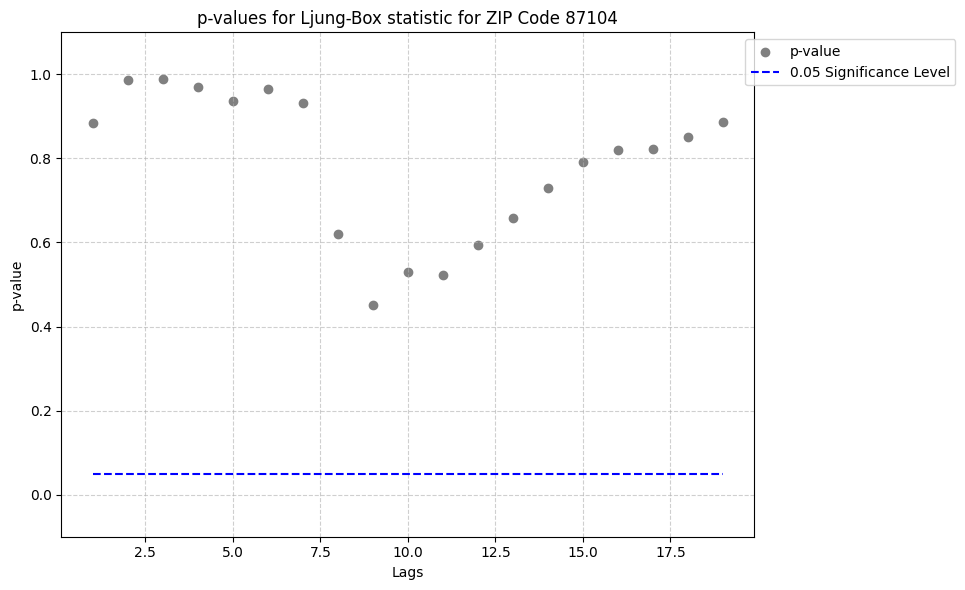


--- Processing data for ZIP Code: 87105 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 1)


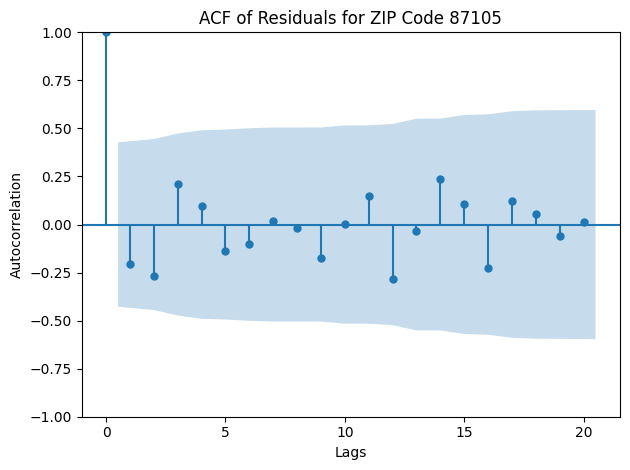

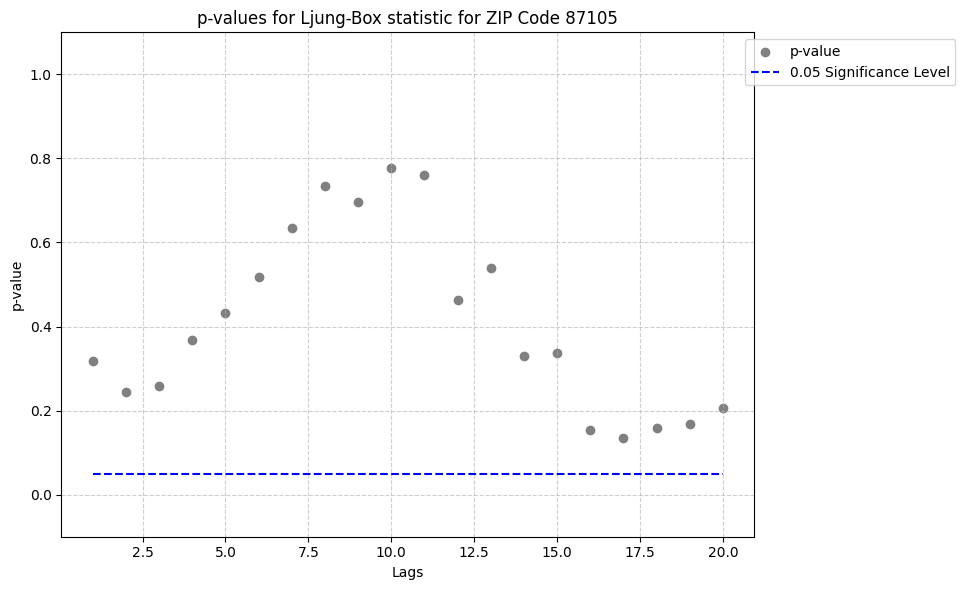


--- Processing data for ZIP Code: 87106 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (1, 0, 0)


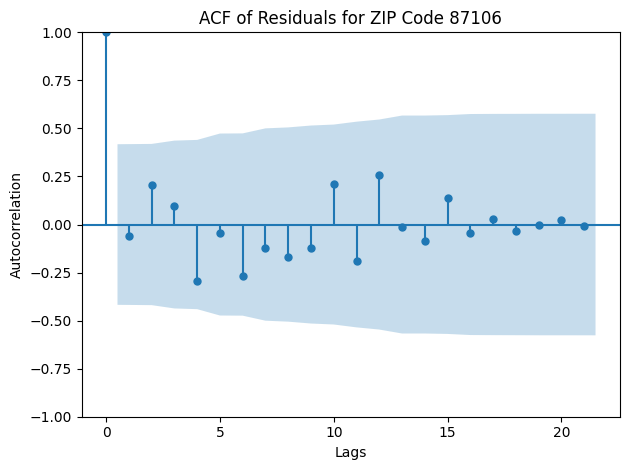

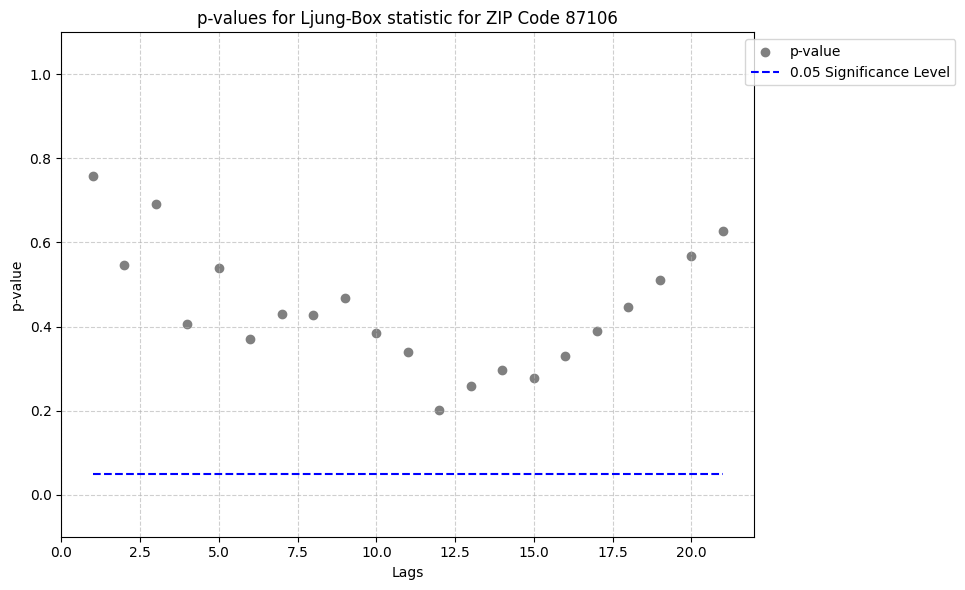


--- Processing data for ZIP Code: 87107 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


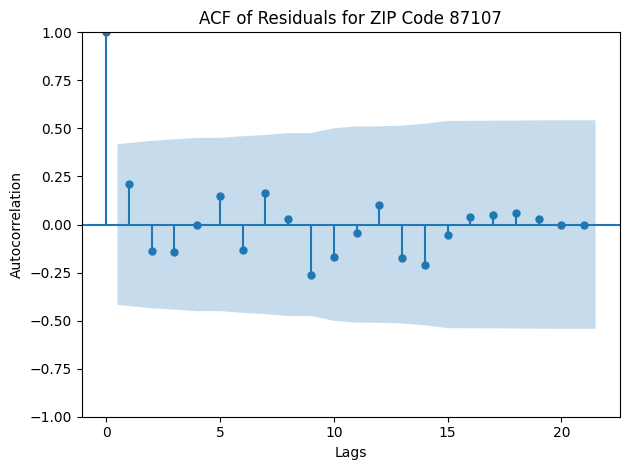

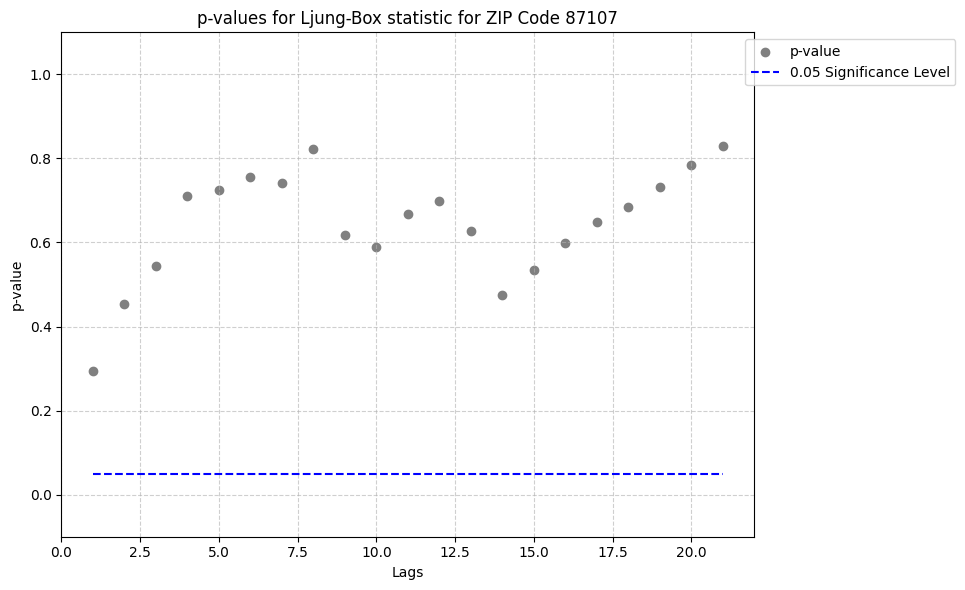


--- Processing data for ZIP Code: 87108 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


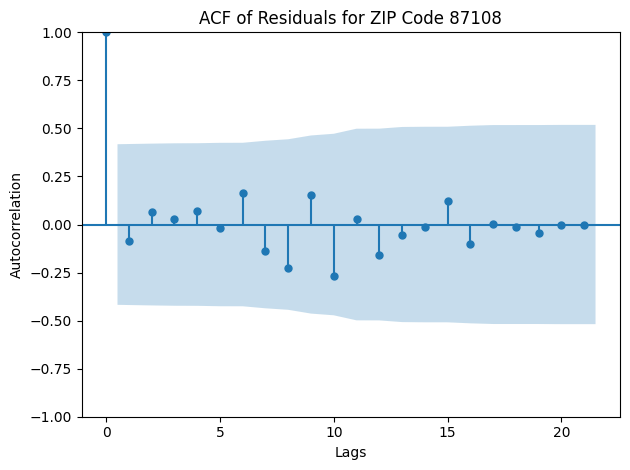

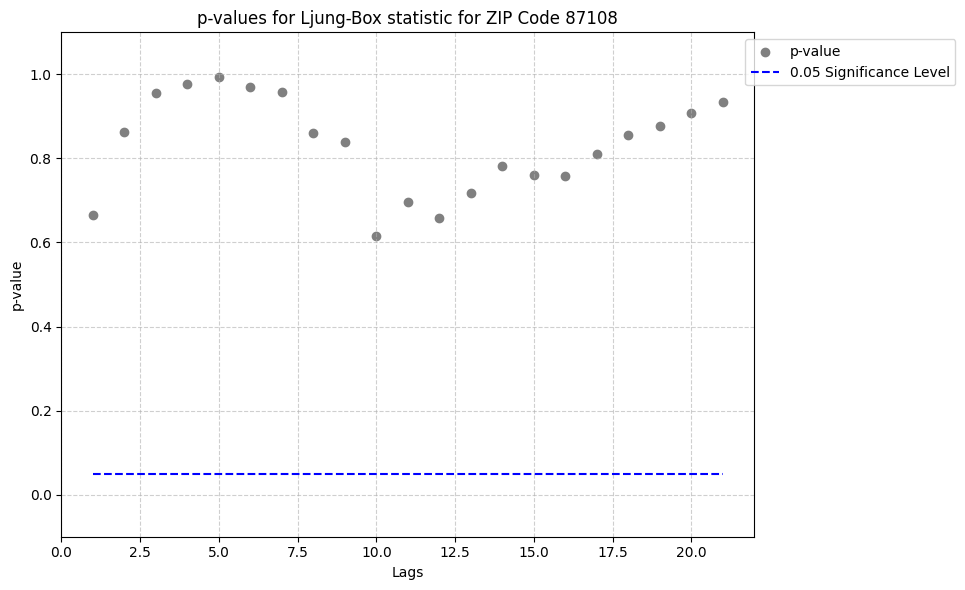


--- Processing data for ZIP Code: 87109 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 1, 1)


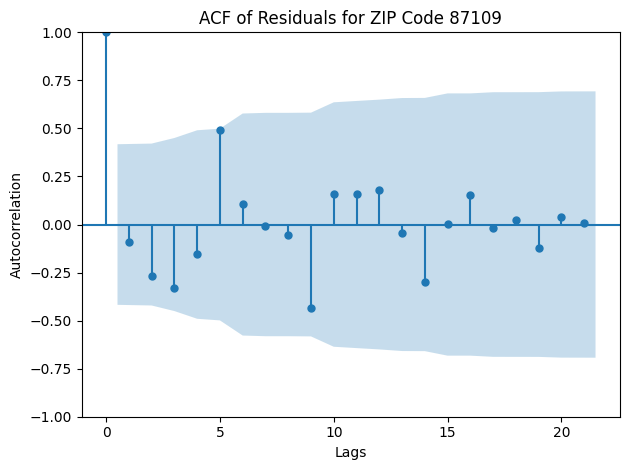

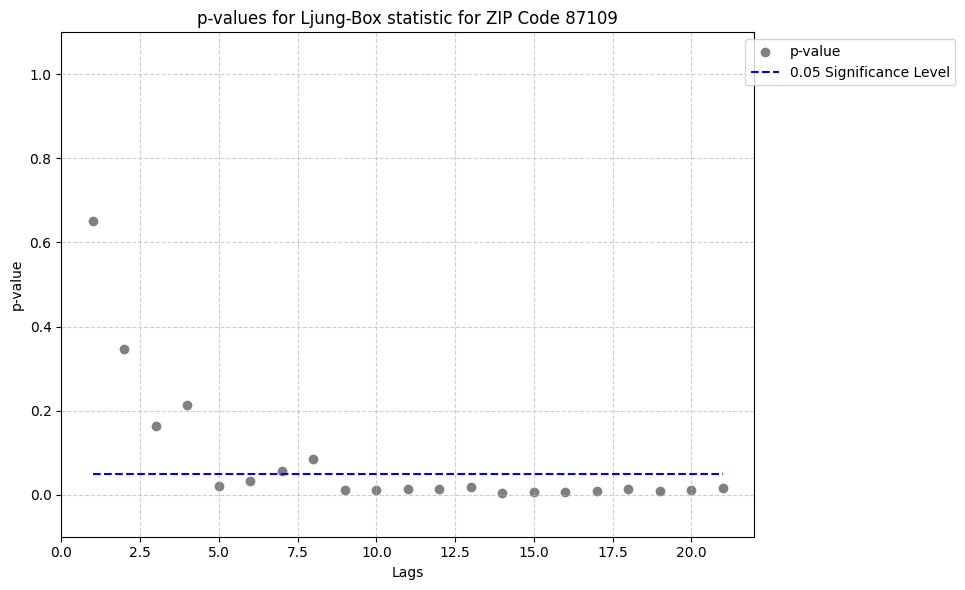


--- Processing data for ZIP Code: 87110 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 1)


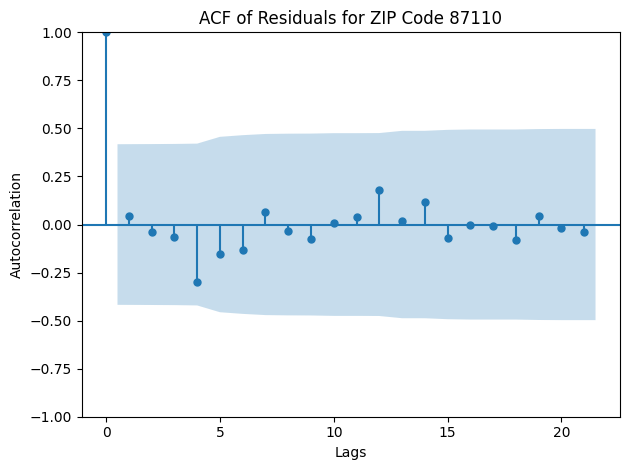

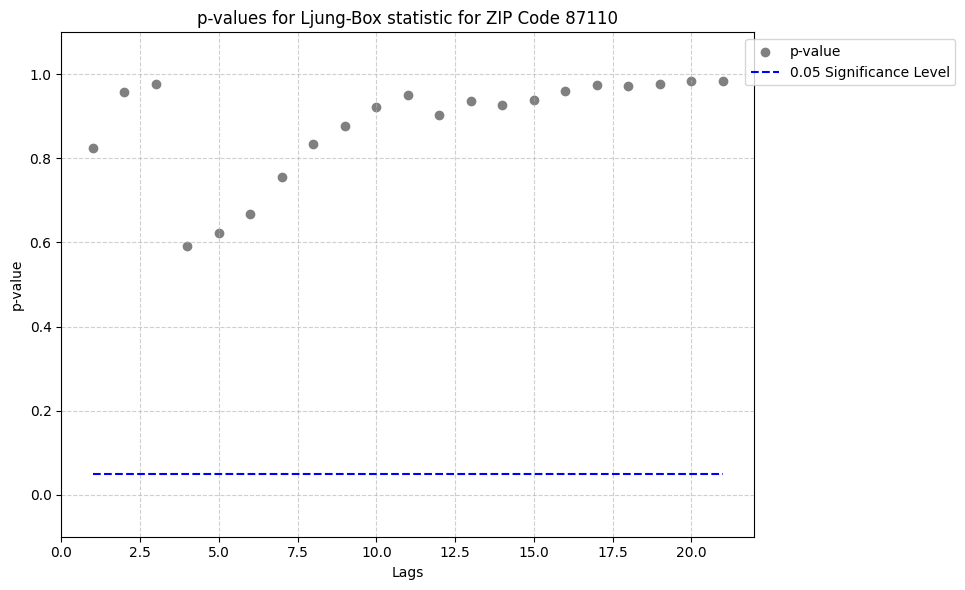


--- Processing data for ZIP Code: 87111 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (1, 0, 1)


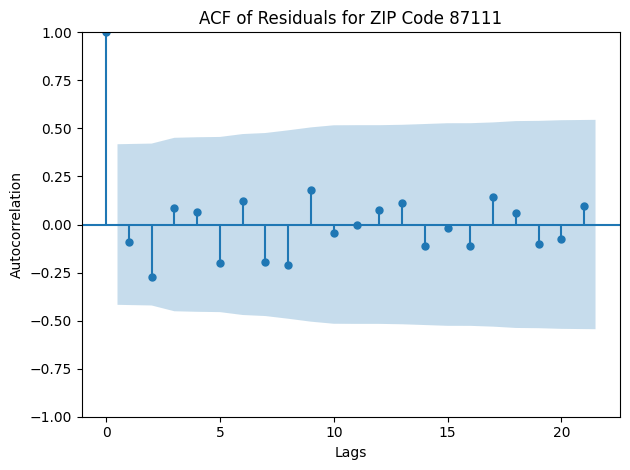

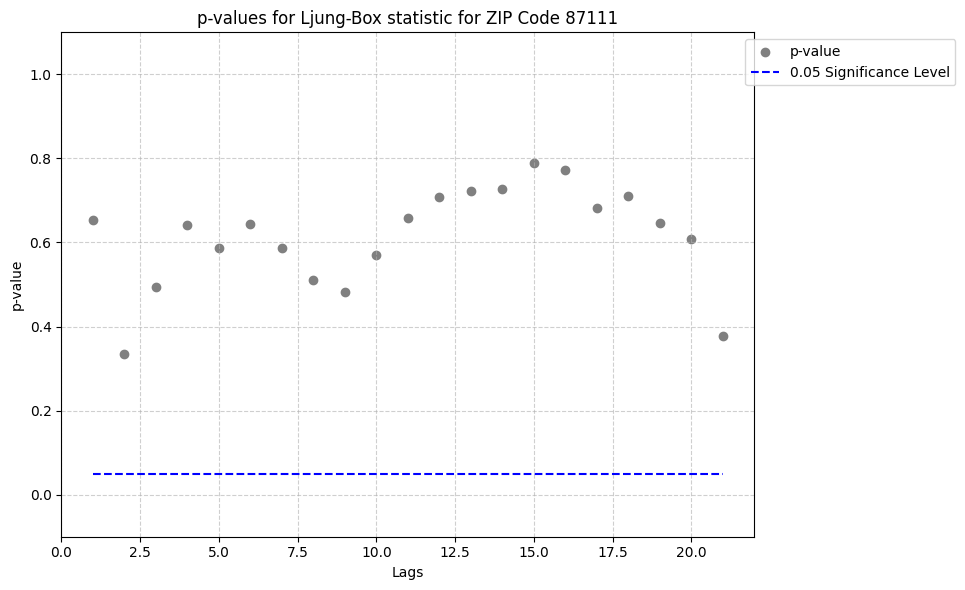


--- Processing data for ZIP Code: 87112 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


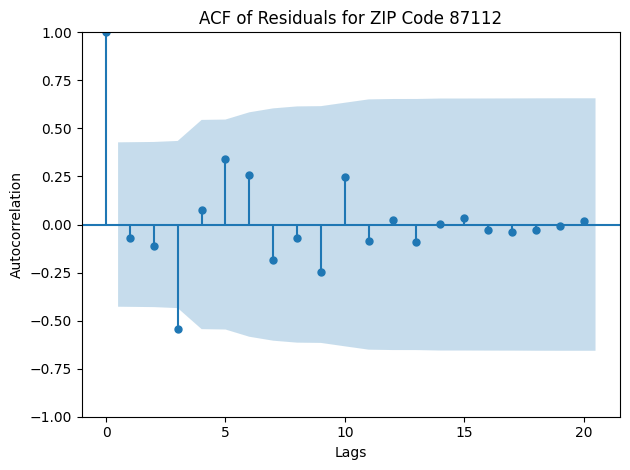

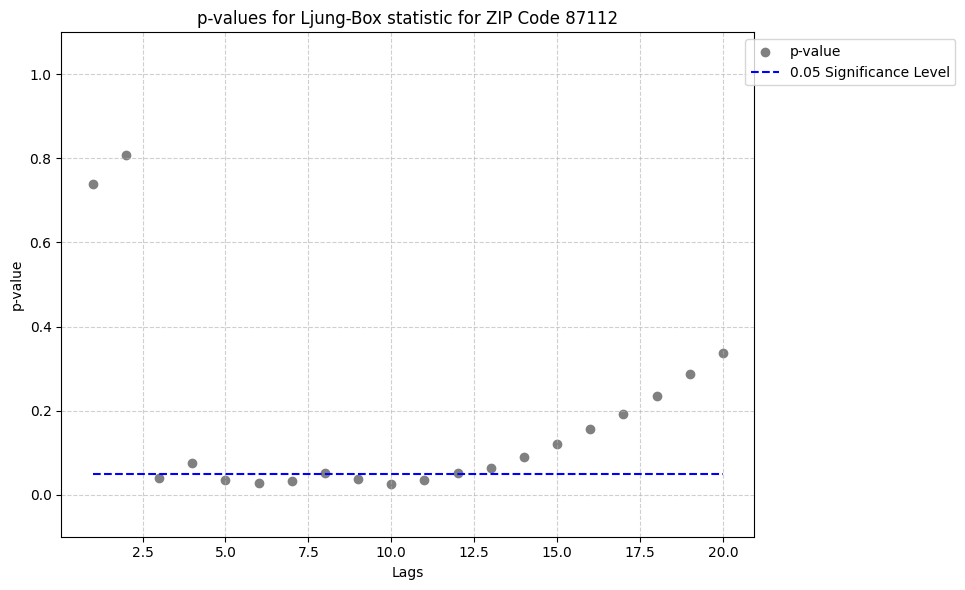


--- Processing data for ZIP Code: 87113 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 1, 1)


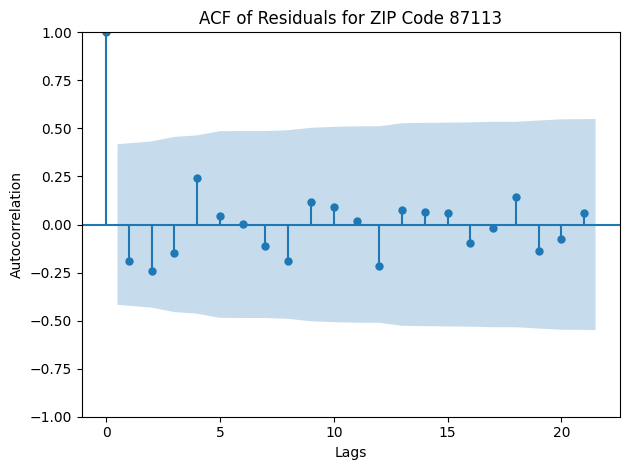

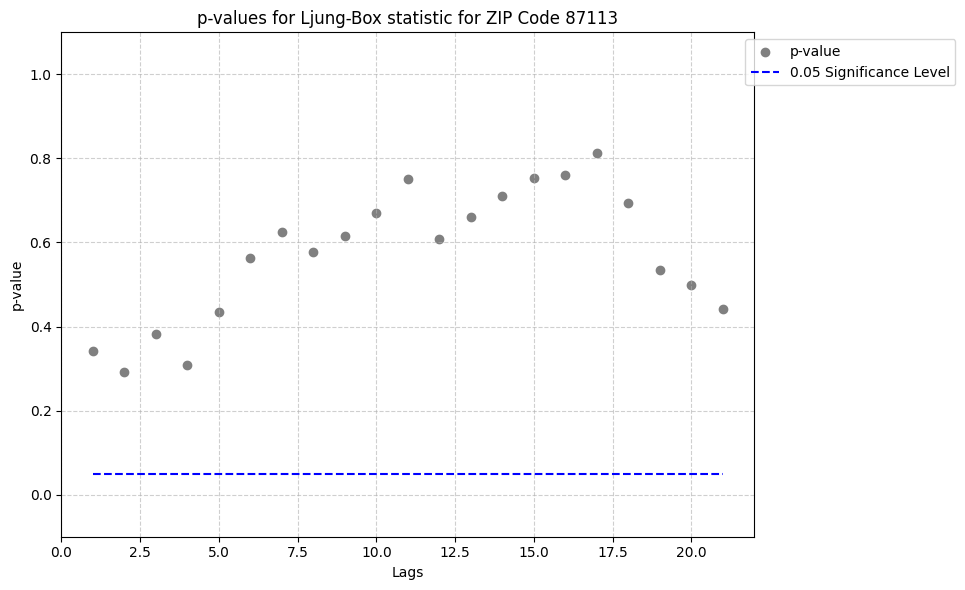


--- Processing data for ZIP Code: 87114 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 1, 2)


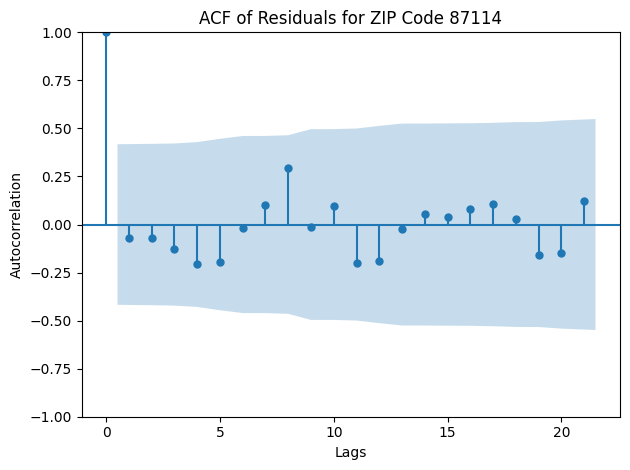

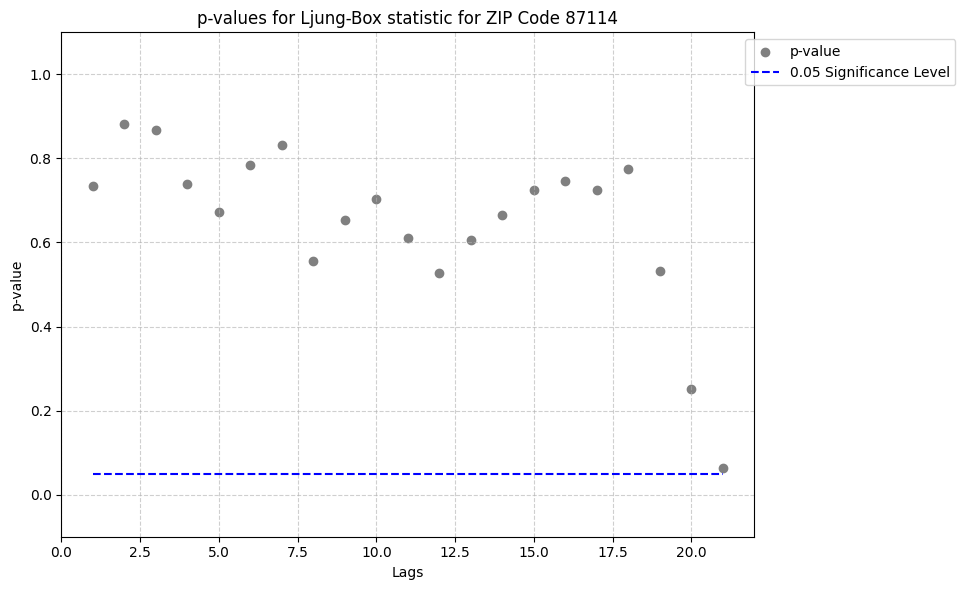


--- Processing data for ZIP Code: 87116 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


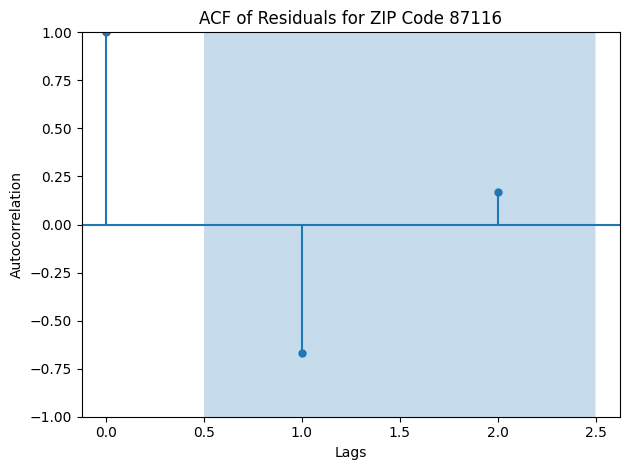

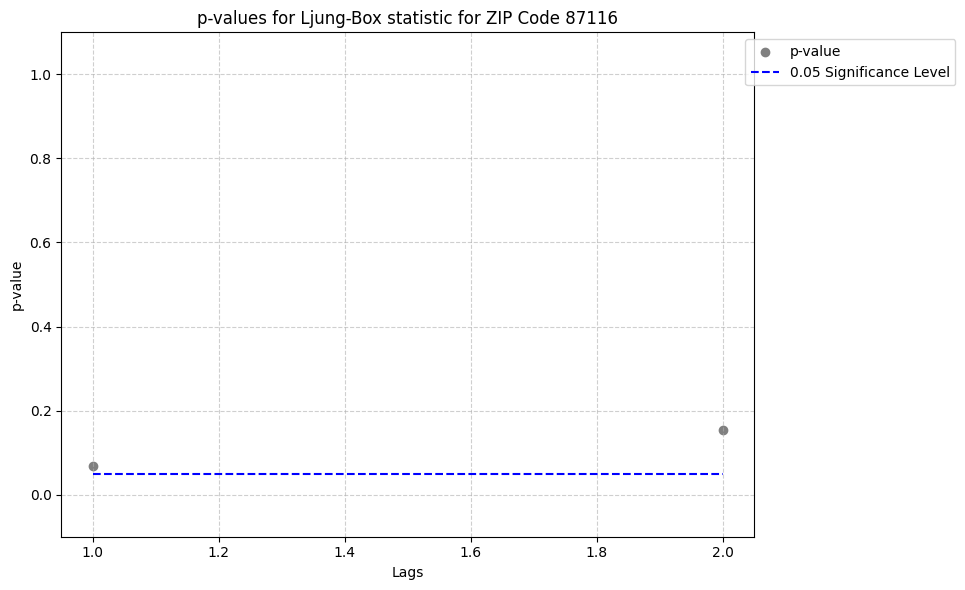


--- Processing data for ZIP Code: 87120 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 1, 1)


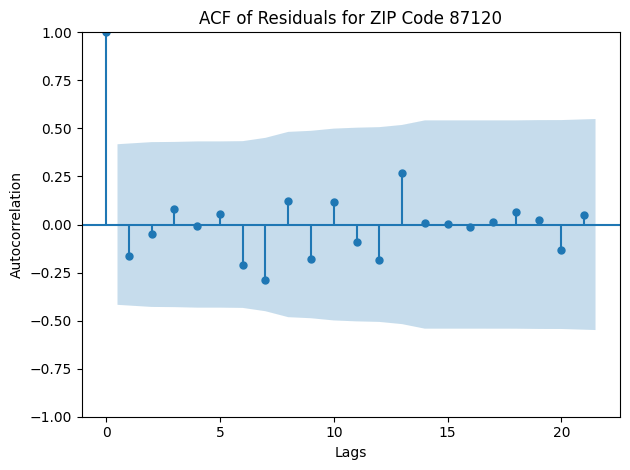

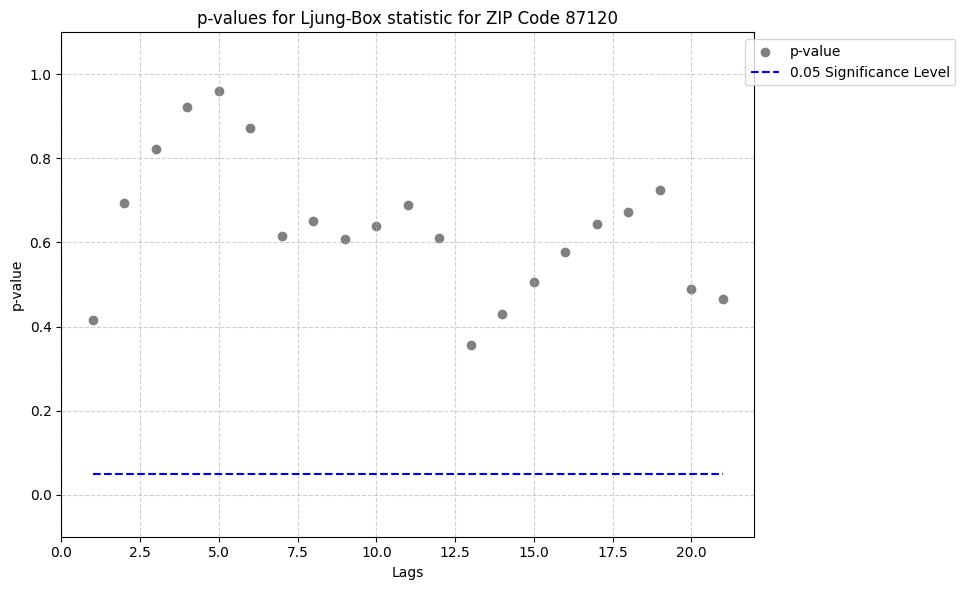


--- Processing data for ZIP Code: 87121 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


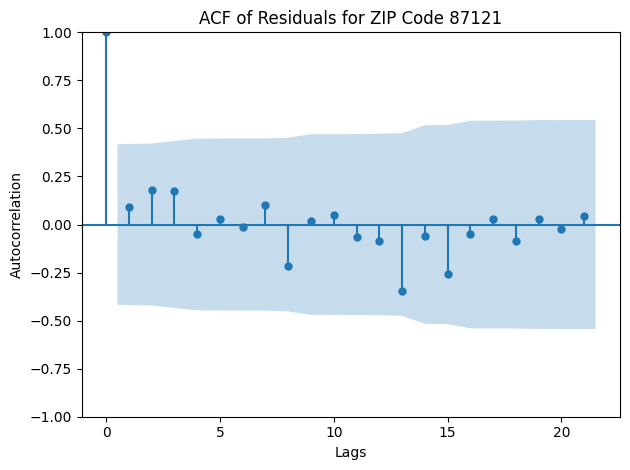

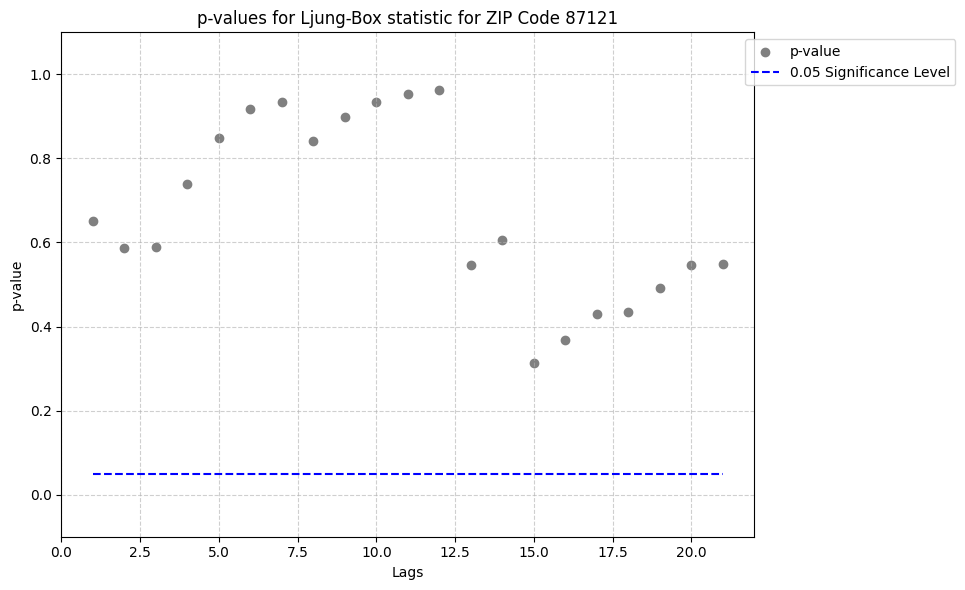


--- Processing data for ZIP Code: 87122 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


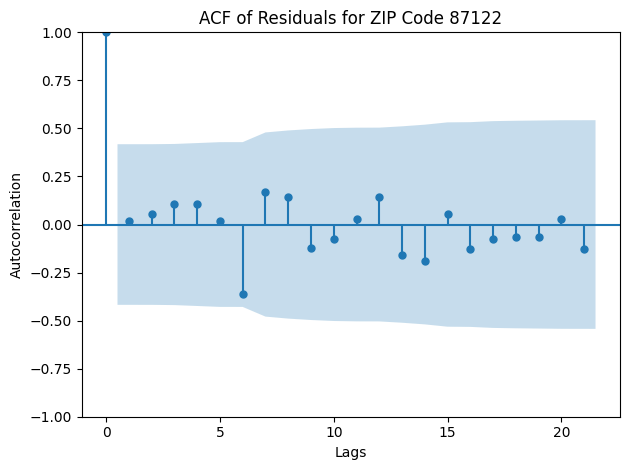

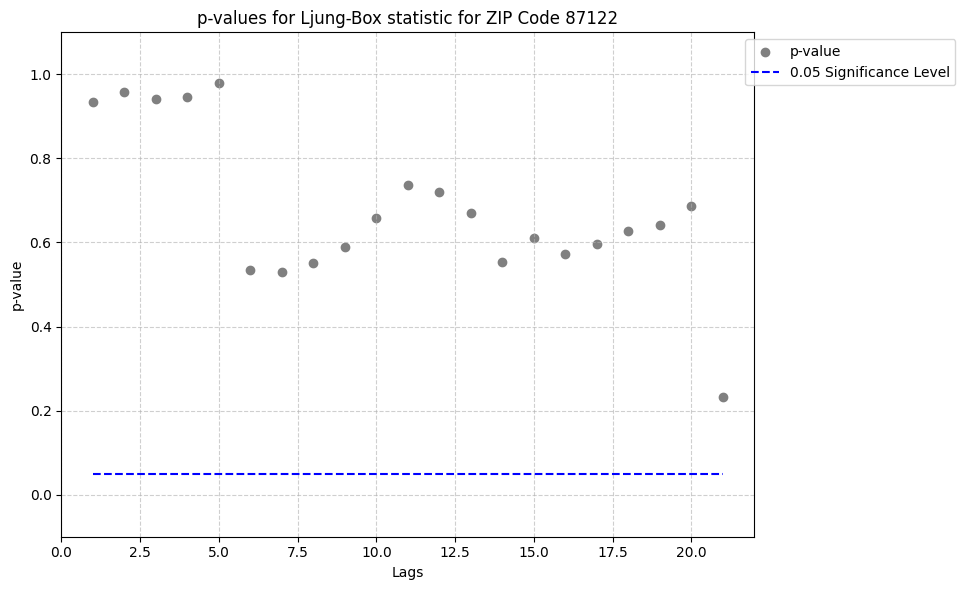


--- Processing data for ZIP Code: 87123 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Order of the non-seasonal ARIMA model: (0, 0, 0)


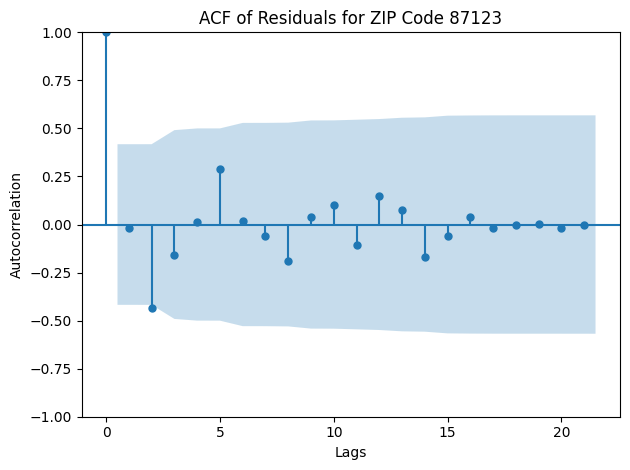

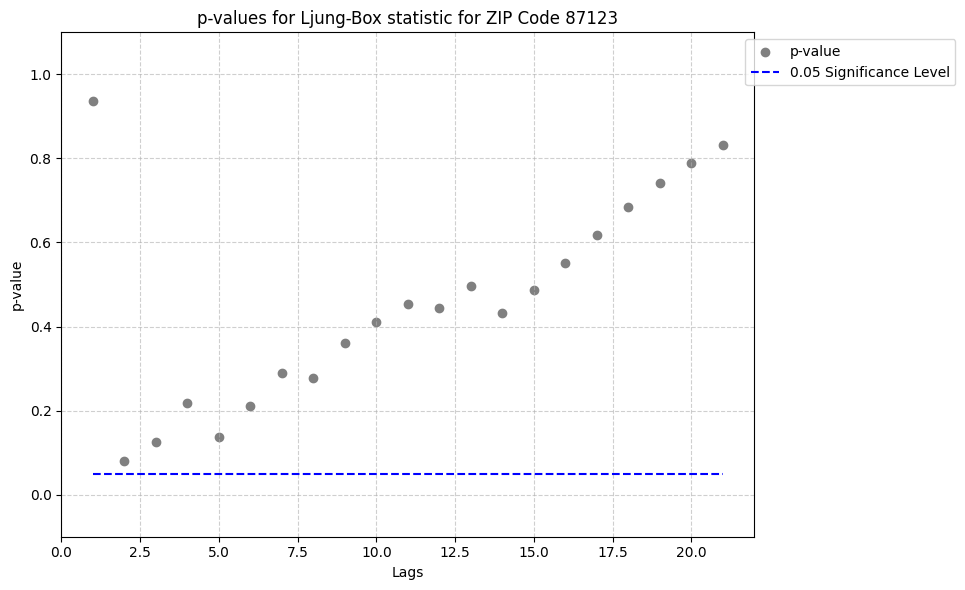

In [70]:
# Step 2: Loop through each unique ZIP code
for zip_code in trn_zip['ZIP Code'].unique():
    print(f"\n--- Processing data for ZIP Code: {zip_code} ---")

    # Step 3: Extract the time series for the current ZIP code
    zip_series_2 = monthly_counts_zip.loc[zip_code]

    # Step 4: Train the non-seasonal auto_arima model
    auto_arima_model2 = auto_arima(zip_series_2, m=12, with_intercept=False,
                                     seasonal=False,
                                     suppress_warnings=True, stepwise=True)

    # Step 5: Print the order set of the model
    print(f"Order of the non-seasonal ARIMA model: {auto_arima_model2.order}")


    # Step 6: Extract the residuals and plot them
    if auto_arima_model2.resid().size > 0:
        resid_zip = auto_arima_model2.resid()

        # --- ACF of Residuals ---
        # Plot the ACF (autocorrelation function) of the residuals
        fig_acf = plot_acf(resid_zip, lags=min(24, len(resid_zip) - 1), title=f'ACF of Residuals for ZIP Code {zip_code}')
        plt.xlabel('Lags')
        plt.ylabel('Autocorrelation')
        plt.tight_layout()
        plt.show()

        # --- Ljung-Box Test p-values ---
        # Plot the p-values of the Ljung-Box test for autocorrelation
        # Ensure lags do not exceed the number of residuals - 1
        max_lags_lb = min(24, len(resid_zip) - 1)
        if max_lags_lb > 0: # Check if there are enough lags to compute
            res_lb = acorr_ljungbox(resid_zip, lags=max_lags_lb, return_df=False)["lb_pvalue"]

            fig, ax = plt.subplots(figsize=(10, 6))
            plt.title(f'p-values for Ljung-Box statistic for ZIP Code {zip_code}')
            plt.scatter(np.arange(1, 1 + len(res_lb)), res_lb, color='gray', label='p-value')
            plt.plot(np.arange(1, 1 + len(res_lb)), [0.05] * len(res_lb), '--', color='blue', label='0.05 Significance Level')
            plt.ylim(-0.1, 1.1)
            plt.xlabel('Lags')
            plt.ylabel('p-value')
            plt.legend(bbox_to_anchor=(1.3, 1))
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Not enough residuals to perform Ljung-Box test for ZIP Code {zip_code}.")

    else:
        print("Could not extract residuals. The model may not have been trained successfully.")


## ARIMA Test Model

- Fit the best model to the training data.

In [73]:
# Resample the data to a monthly frequency and sum the vehicle counts
monthly_counts_zip = trn_zip.groupby('ZIP Code')['Vehicle Count'].resample('MS').sum().reset_index()
monthly_counts_zip.set_index('Registration Date', inplace=True)


--- Forecasting for ZIP Code: 87102 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

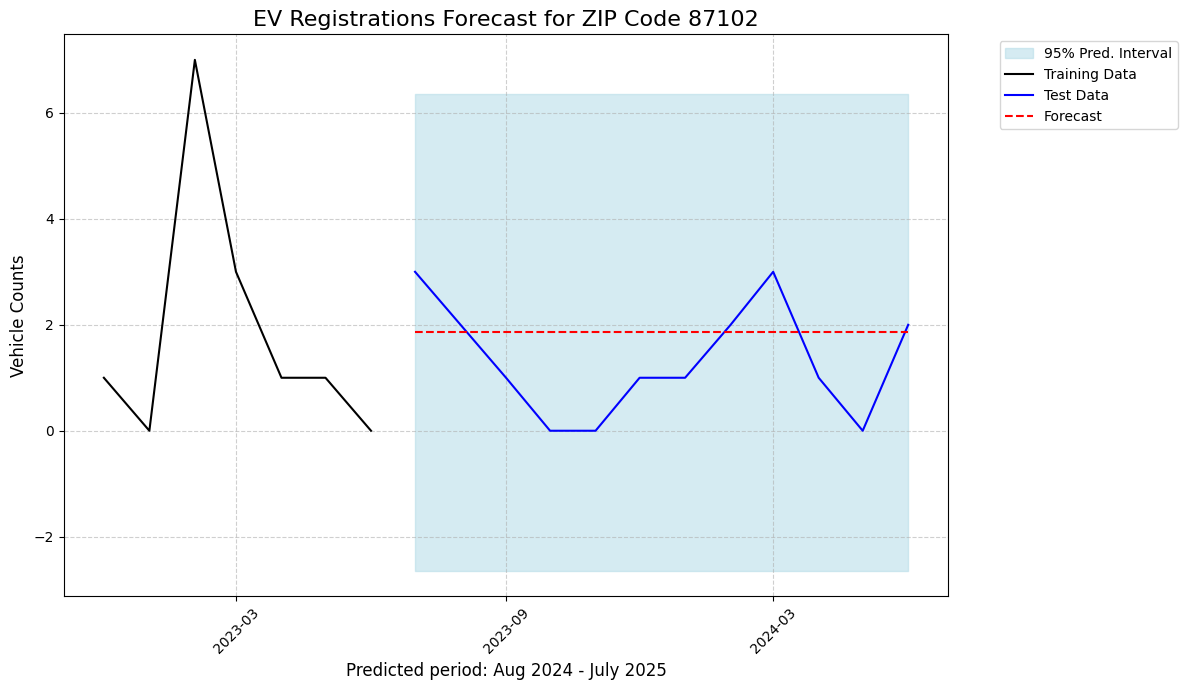


--- Forecasting for ZIP Code: 87104 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

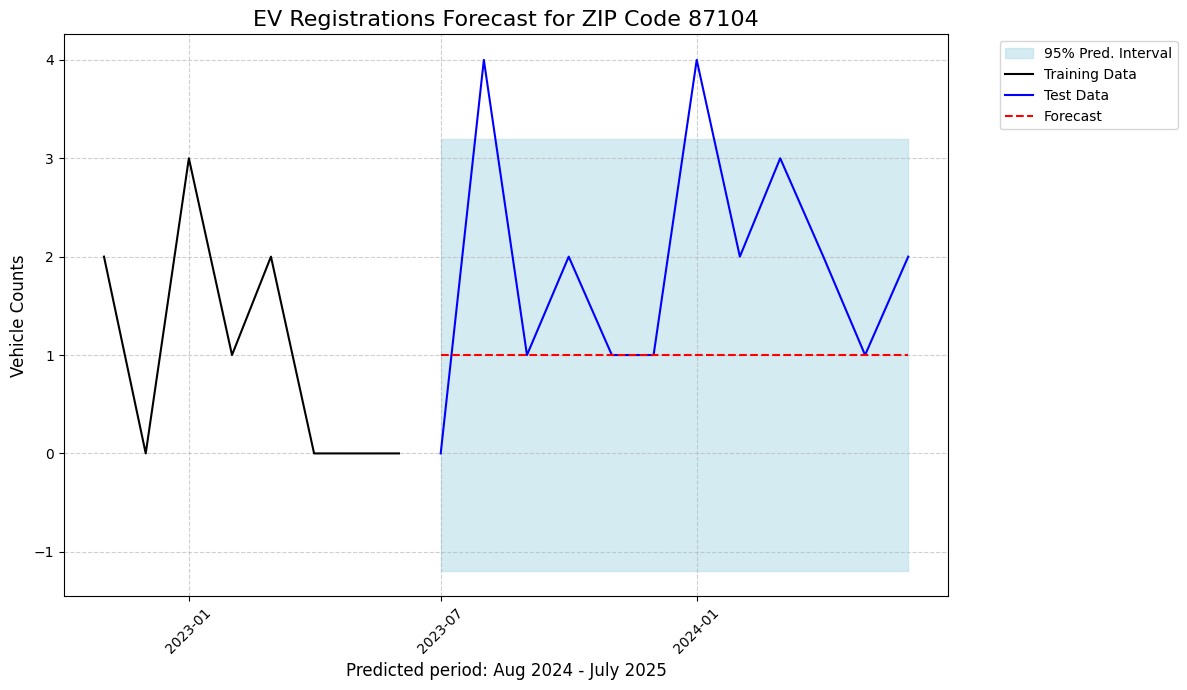


--- Forecasting for ZIP Code: 87105 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

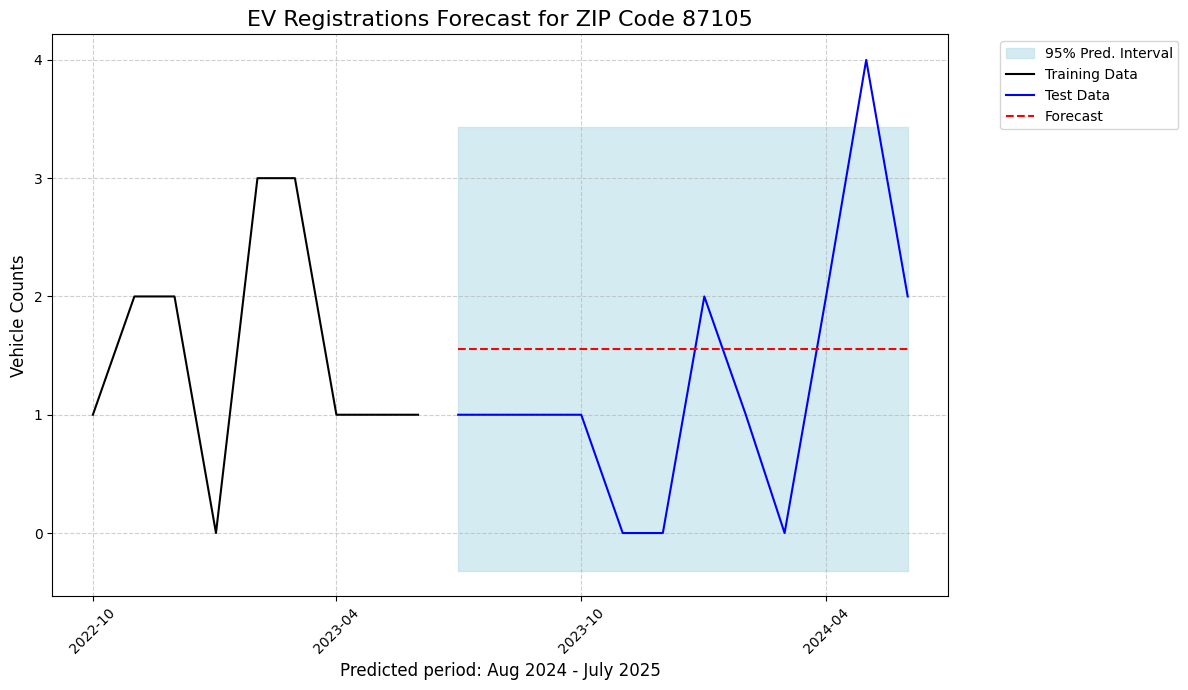


--- Forecasting for ZIP Code: 87106 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

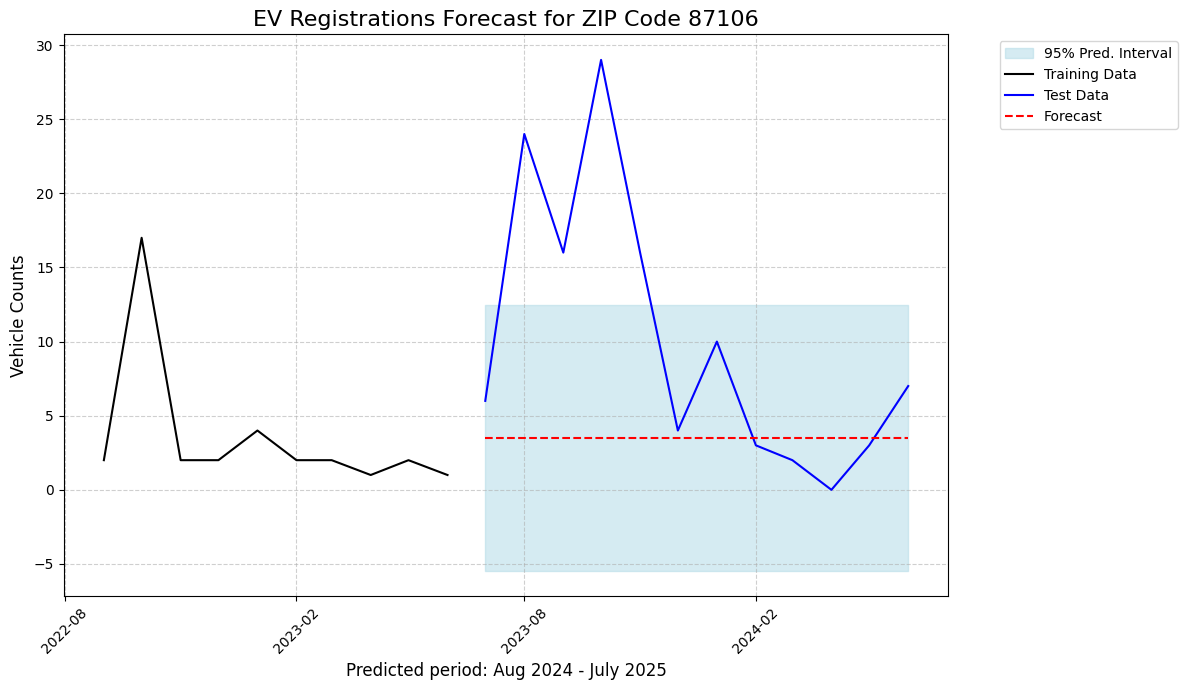


--- Forecasting for ZIP Code: 87107 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

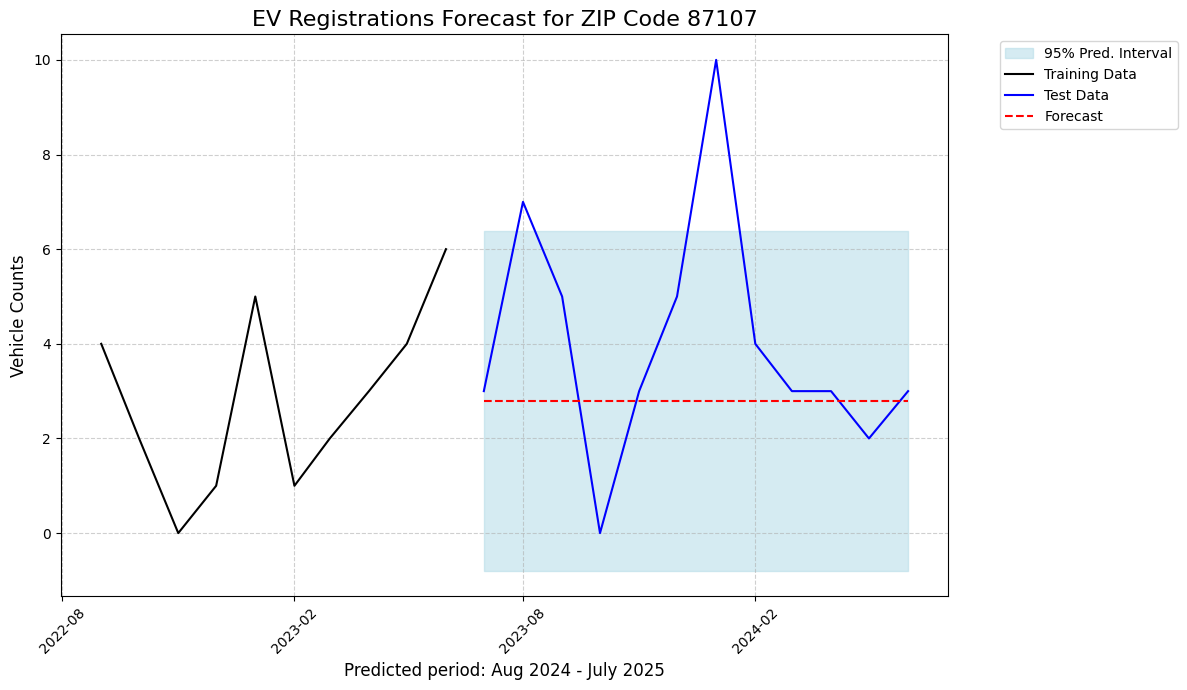


--- Forecasting for ZIP Code: 87108 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

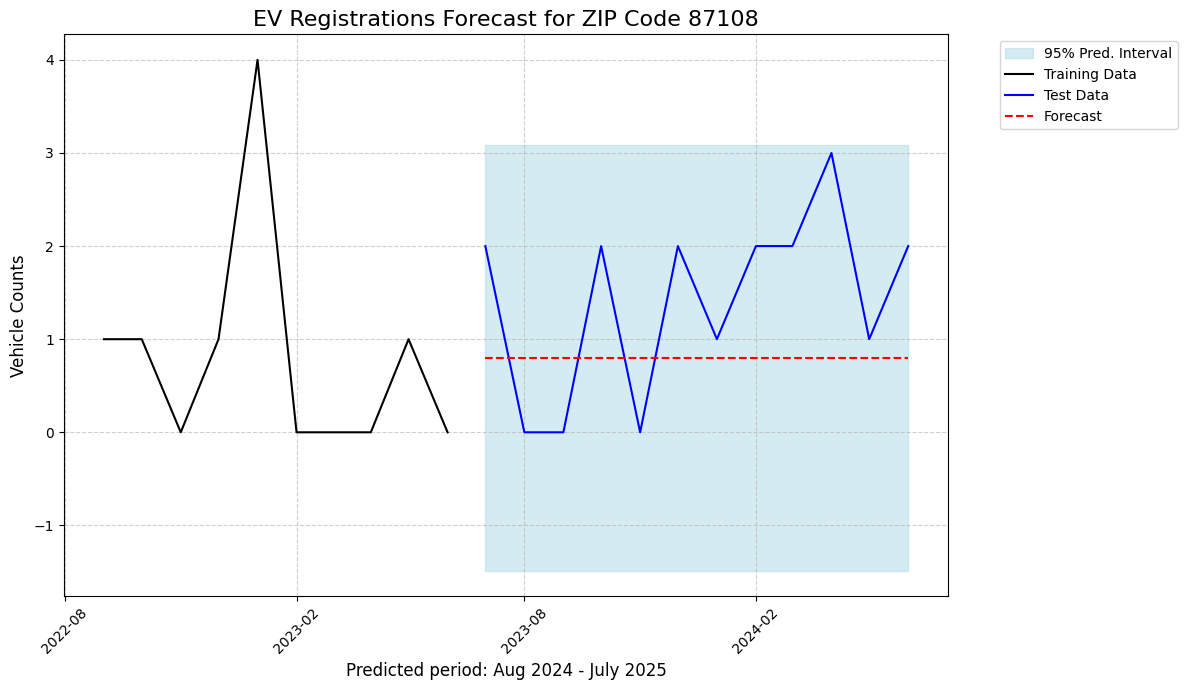


--- Forecasting for ZIP Code: 87109 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

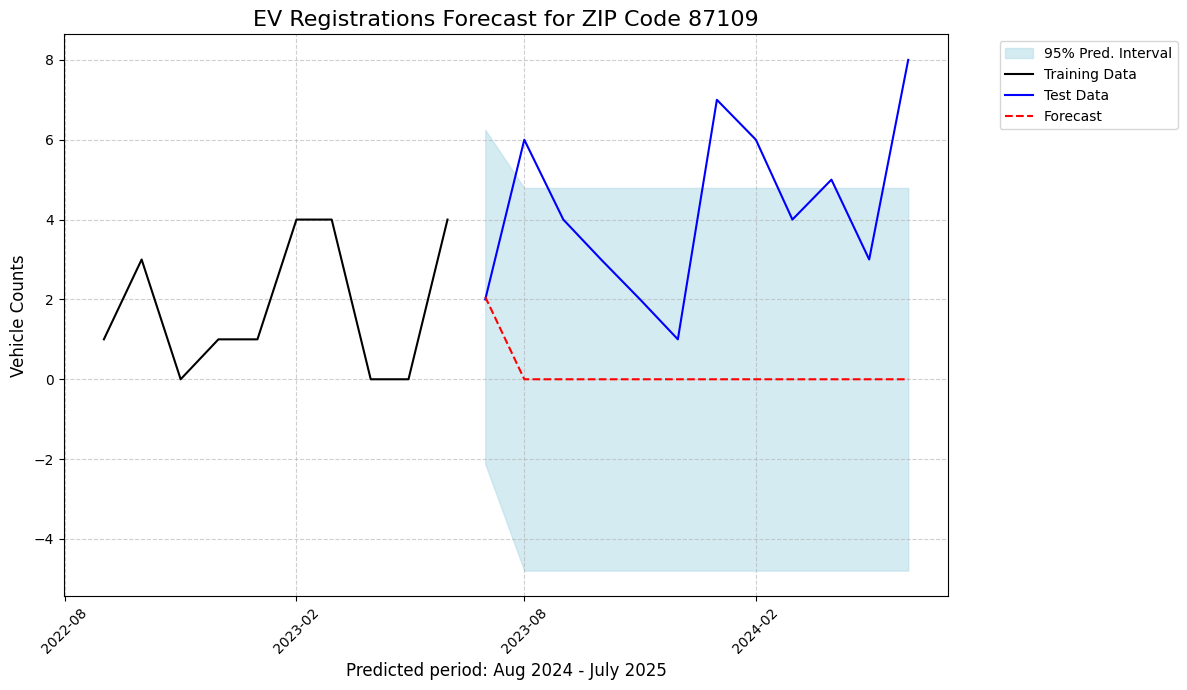


--- Forecasting for ZIP Code: 87110 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

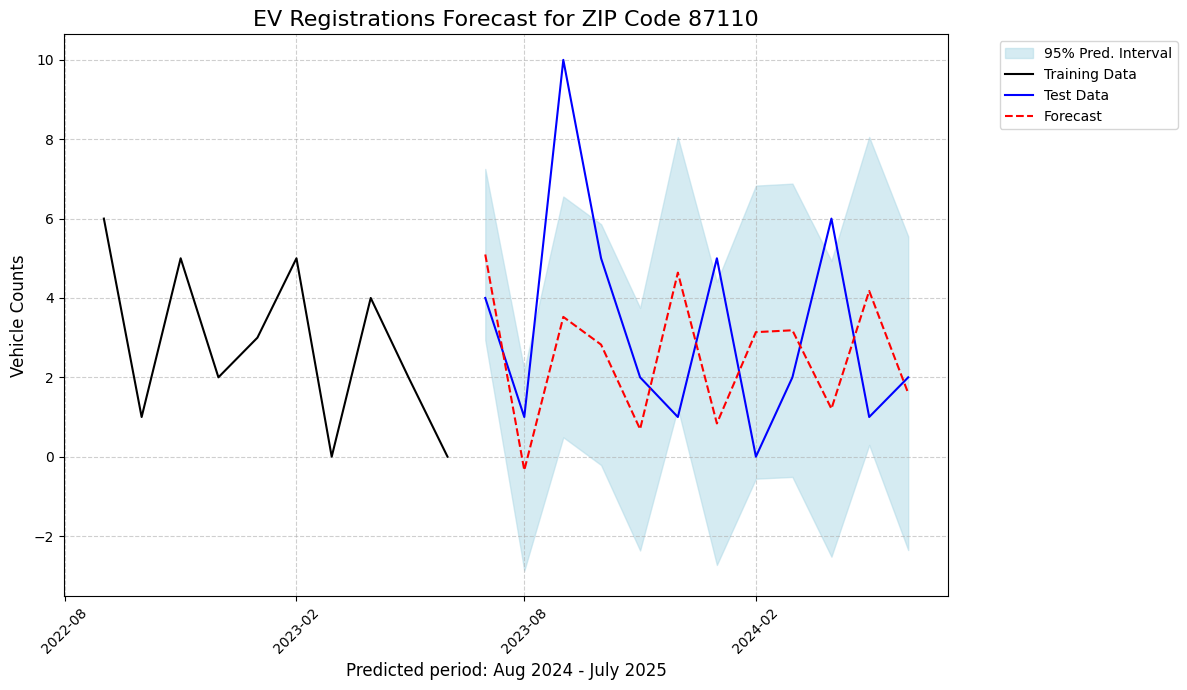


--- Forecasting for ZIP Code: 87111 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

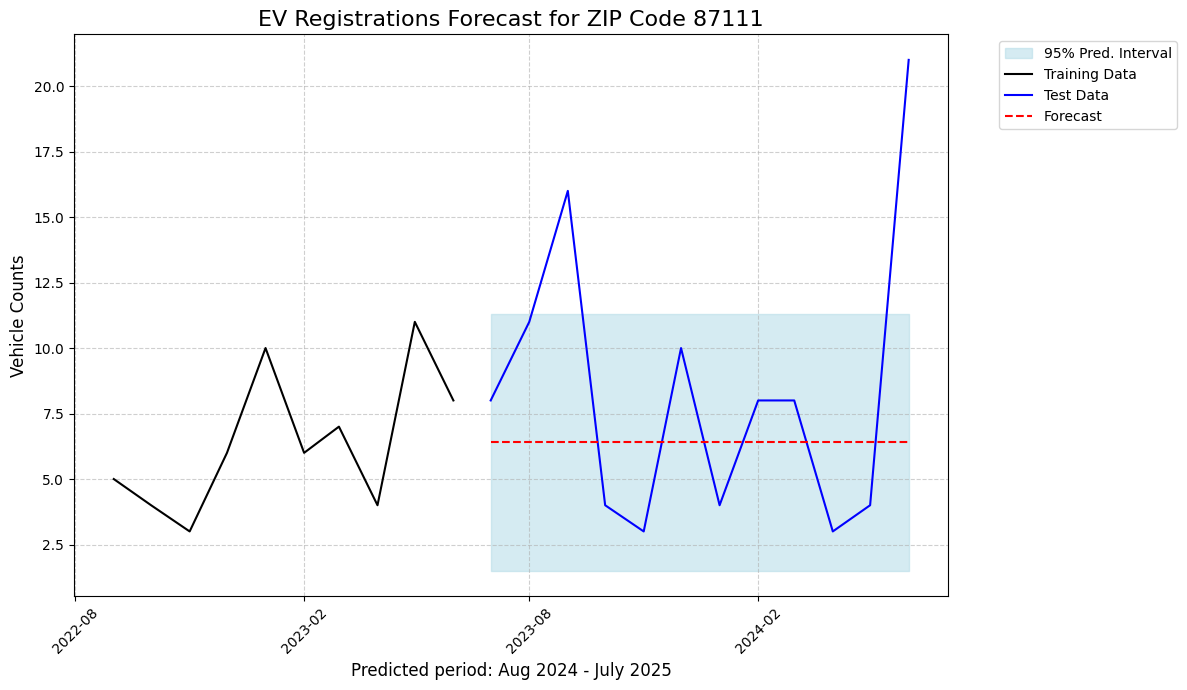


--- Forecasting for ZIP Code: 87112 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

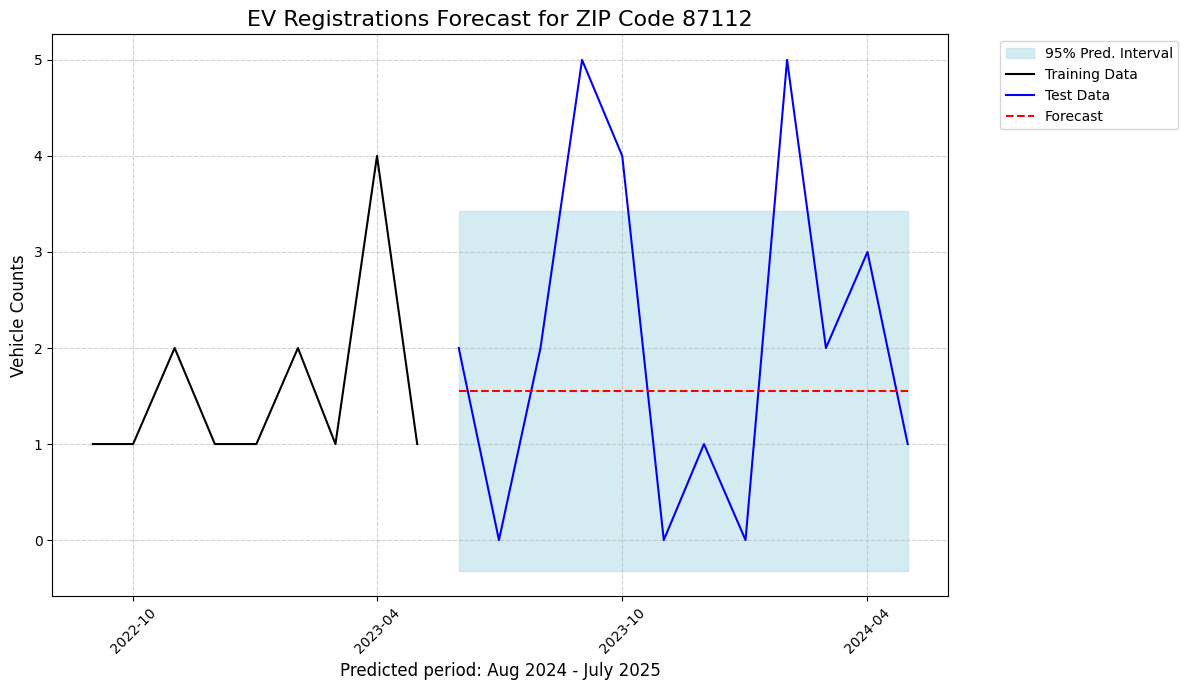


--- Forecasting for ZIP Code: 87113 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

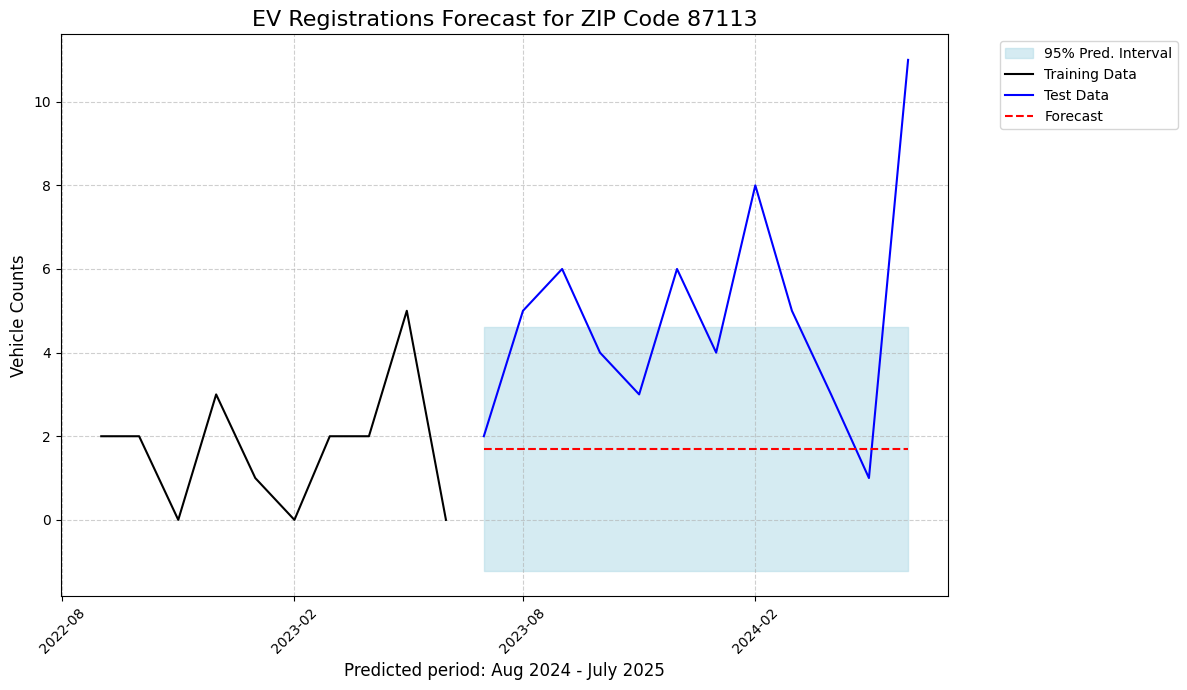


--- Forecasting for ZIP Code: 87114 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

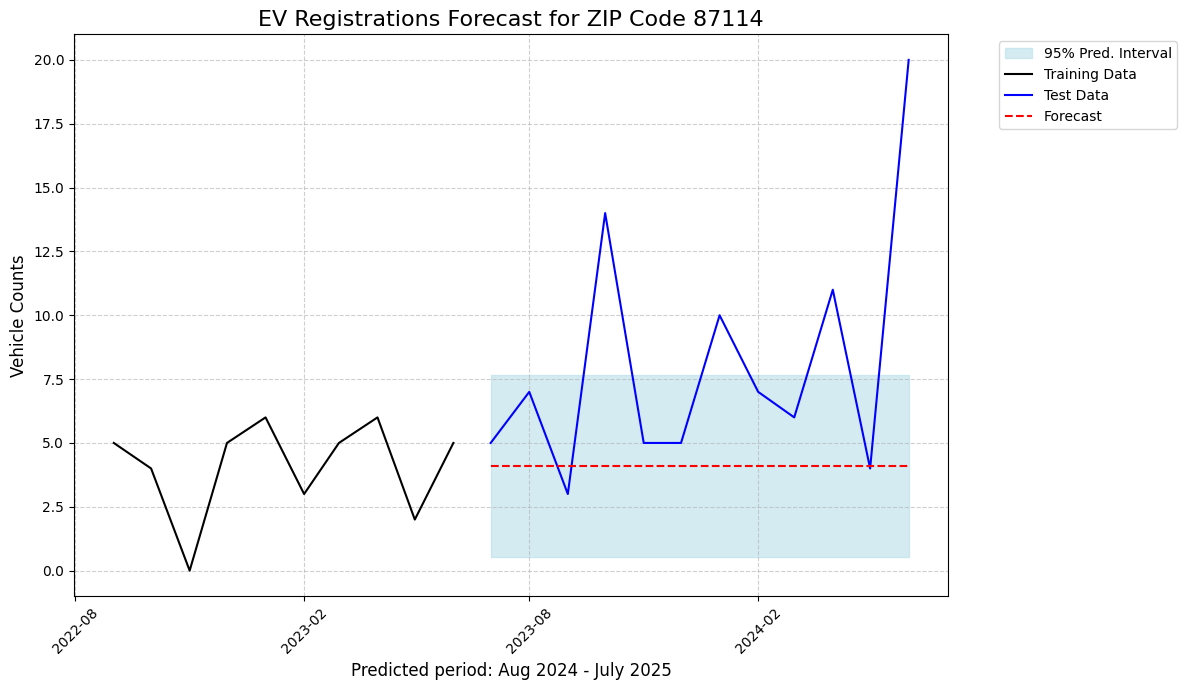


--- Forecasting for ZIP Code: 87116 ---
Skipping ZIP code 87116: Not enough data for a training/testing split (requires more than 12 months).

--- Forecasting for ZIP Code: 87120 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

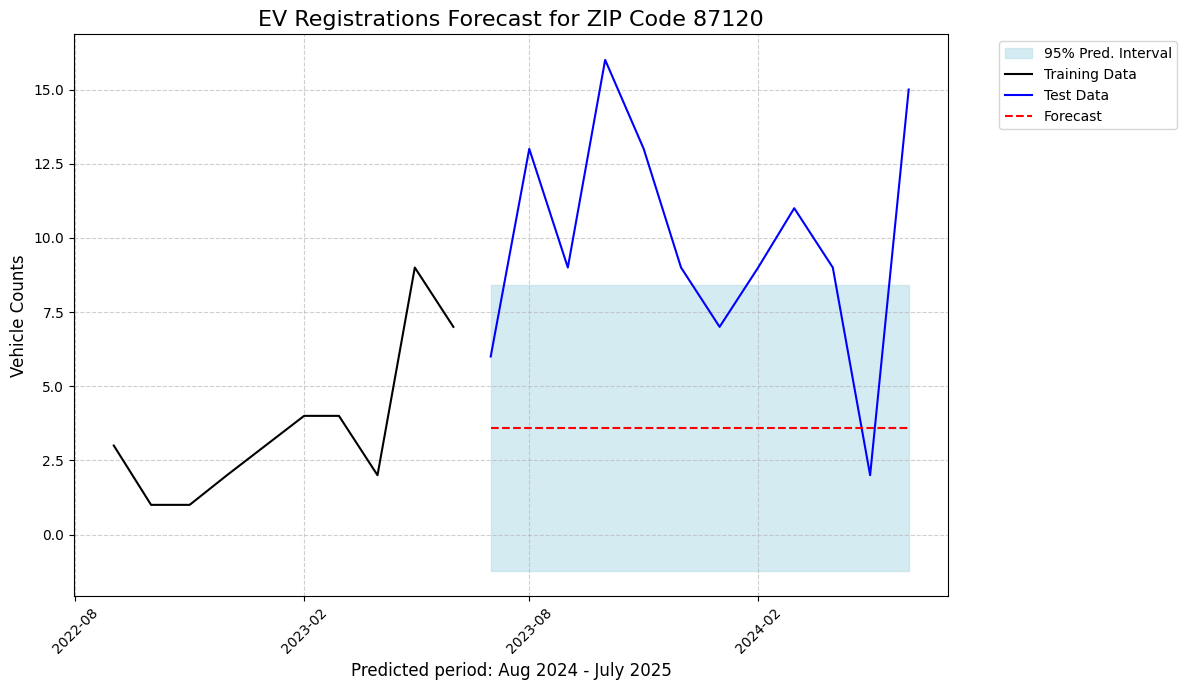


--- Forecasting for ZIP Code: 87121 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

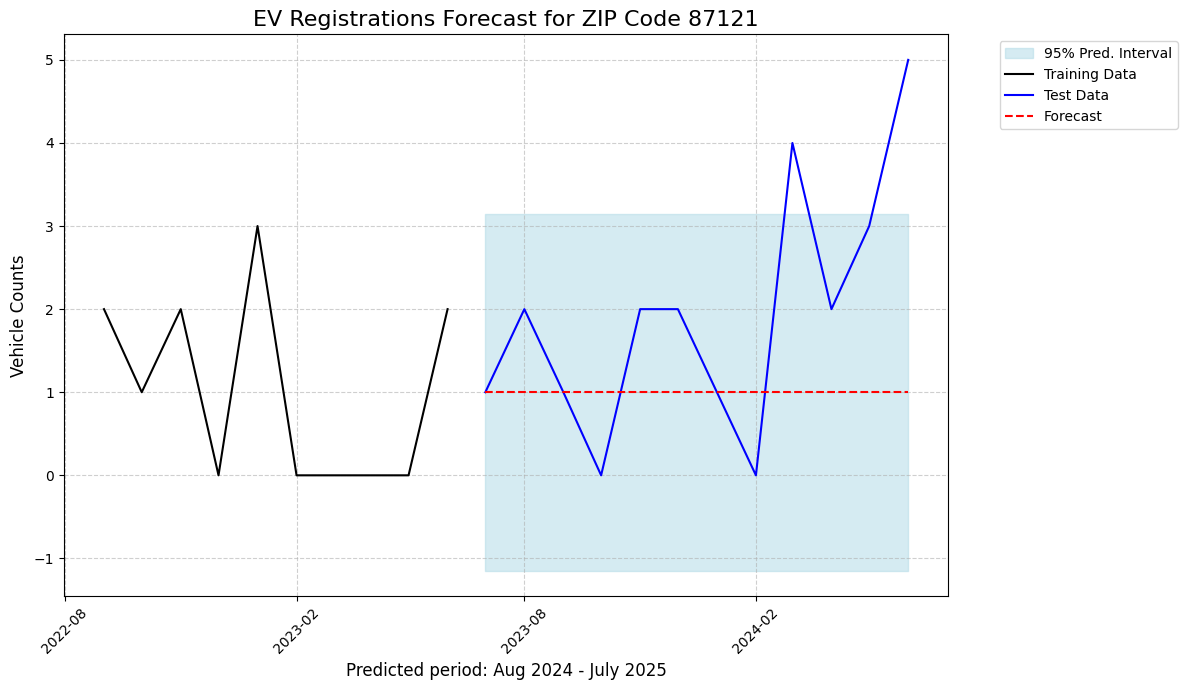


--- Forecasting for ZIP Code: 87122 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

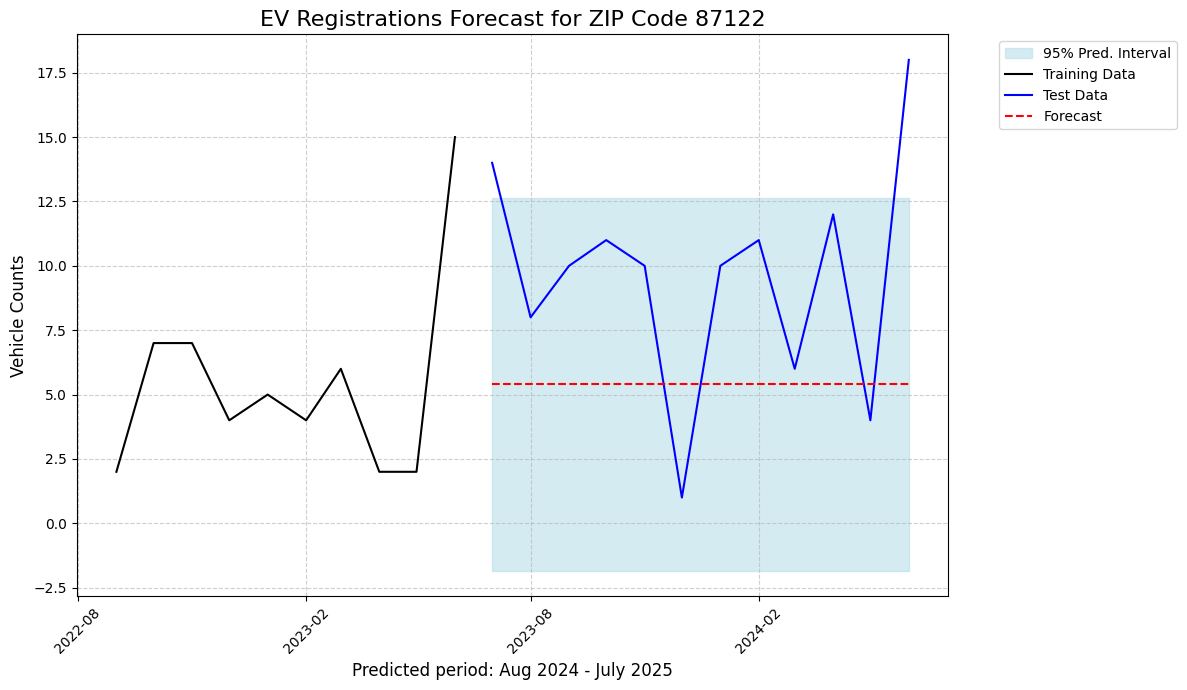


--- Forecasting for ZIP Code: 87123 ---


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

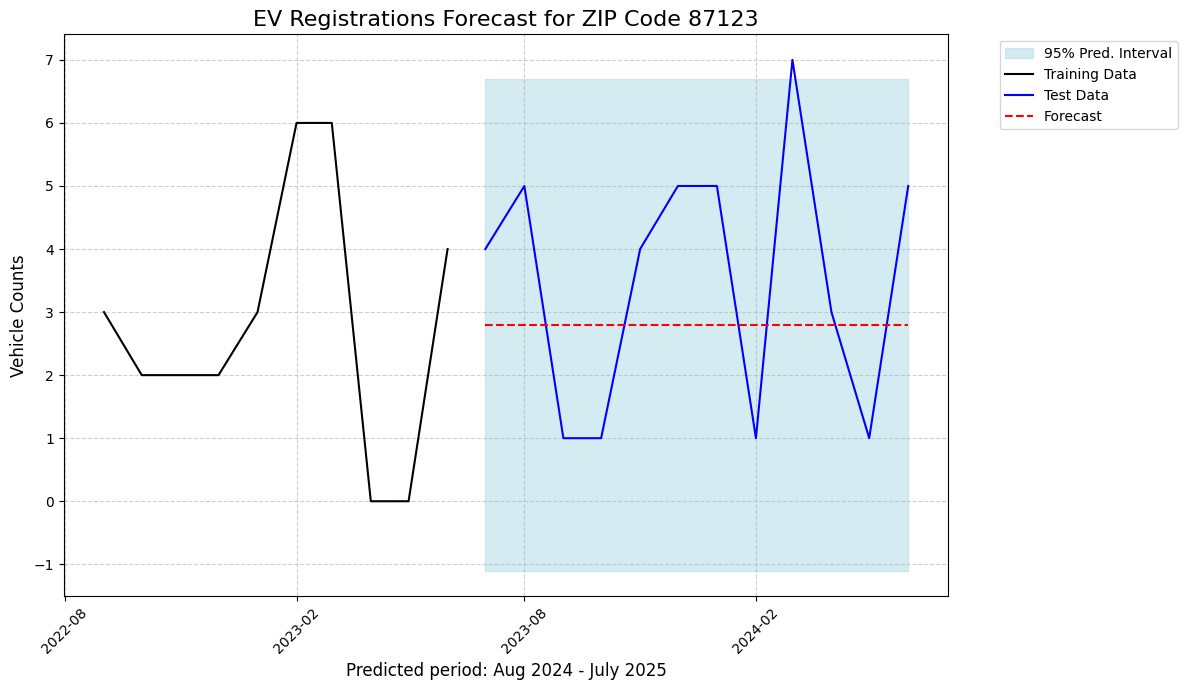

In [77]:
# Resample the data to a monthly frequency and sum the vehicle counts
monthly_counts_zip = trn_zip.groupby('ZIP Code')['Vehicle Count'].resample('MS').sum().reset_index()
monthly_counts_zip.set_index('Registration Date', inplace=True)

# Loop through each unique ZIP code
for zip_code in monthly_counts_zip['ZIP Code'].unique():
    print(f"\n--- Forecasting for ZIP Code: {zip_code} ---")

    # Extract the time series for the current ZIP code
    zip_series_tst = monthly_counts_zip.loc[monthly_counts_zip['ZIP Code'] == zip_code]['Vehicle Count']

    # Define the training and testing data
    # Use the first 24 months for training, the last 12 months for testing
    # Ensure there's at least one data point for the training set
    if len(zip_series_tst) > 12: # Only proceed if there's enough data for a test split
        trn_zip_data = zip_series_tst.iloc[:-12]
        tst_zip_data = zip_series_tst.iloc[-12:]

        # Fit the best non-seasonal model to the training data
        auto_arima_model_tst = auto_arima(trn_zip_data, m=12, with_intercept=False,
                                          seasonal=False,
                                          suppress_warnings=True, stepwise=True)

        # Use the model to predict intervals for the testing period
        arima_predictions = auto_arima_model_tst.predict(n_periods=len(tst_zip_data), alpha=0.05, return_conf_int=True)

        # Extract the time series of model predictions
        y_pred = pd.Series(arima_predictions[0], index=tst_zip_data.index)

        # Extract the 95% prediction interval
        y_pred_lb, y_pred_ub = arima_predictions[1][:, 0], arima_predictions[1][:, 1]

        # --- Plotting section ---
        fig, ax = plt.subplots(figsize=(12, 7))

        plt.fill_between(tst_zip_data.index, y_pred_lb, y_pred_ub,
                         color='lightblue', alpha=0.5, label='95% Pred. Interval')

        plt.plot(trn_zip_data.index, trn_zip_data, color='black', label='Training Data')
        plt.plot(tst_zip_data.index, tst_zip_data, color='blue', label='Test Data')
        plt.plot(y_pred.index, y_pred, color='red', linestyle='--', label='Forecast')

        plt.title(f'EV Registrations Forecast for ZIP Code {zip_code}', fontsize=16)
        plt.xlabel('Predicted period: Aug 2024 - July 2025', fontsize=12)
        plt.ylabel('Vehicle Counts', fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.6)

        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(MonthLocator(interval=6))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
      print(f"Skipping ZIP code {zip_code}: Not enough data for a training/testing split (requires more than 12 months).")


- Create a dataframe with the observed values for the testing dataset.

- Add the predictions from the ARIMA model.

- Add the low and high boundaries for the 95% confidence intervals.

In [80]:
# --- To report the predicted data in a new DataFrame named tst_pred ---

# Loop through each unique ZIP code
for zip_code in monthly_counts_zip['ZIP Code'].unique():
    print(f"\n--- Test Predictions for ZIP Code: {zip_code} ---")
    tst_pred = pd.DataFrame({
        'Actual': tst_zip_data.values, # Use tst_zip_data for actual values
        'Point Forecast': y_pred.values,
        'Lo 95': y_pred_lb,
        'Hi 95': y_pred_ub
        }, index=tst_zip_data.index) # Use tst_zip_data.index for the index
    print(tst_pred)



--- Test Predictions for ZIP Code: 87102 ---
                   Actual  Point Forecast     Lo 95     Hi 95
Registration Date                                            
2023-07-01              4             2.8 -1.100279  6.700279
2023-08-01              5             2.8 -1.100279  6.700279
2023-09-01              1             2.8 -1.100279  6.700279
2023-10-01              1             2.8 -1.100279  6.700279
2023-11-01              4             2.8 -1.100279  6.700279
2023-12-01              5             2.8 -1.100279  6.700279
2024-01-01              5             2.8 -1.100279  6.700279
2024-02-01              1             2.8 -1.100279  6.700279
2024-03-01              7             2.8 -1.100279  6.700279
2024-04-01              3             2.8 -1.100279  6.700279
2024-05-01              1             2.8 -1.100279  6.700279
2024-06-01              5             2.8 -1.100279  6.700279

--- Test Predictions for ZIP Code: 87104 ---
                   Actual  Point Forecas